## 🔗 Python & R Integration with .NET Interactive

In this section, I demonstrate how to connect Python and R kernels to the .NET Interactive system, allowing for seamless use of Python, R, and other languages together in a single notebook.

In [1]:
#!connect jupyter --kernel-name phd-python --conda-env phd --kernel-spec python3

The `#!connect jupyter` feature is in preview. Please report any feedback or issues at https://github.com/dotnet/interactive/issues/new/choose.

Kernel added: #!phd-python

In [ ]:
#!connect jupyter --kernel-name Rkernel --conda-env phd --kernel-spec ir

## 🐍 Python: Library Import and Global Variable Definition

In this section, I import my necessary libraries 📚 and define global variables 🌐 (mostly path-related). These variables can be reused throughout the code to adapt to different locations or users.

In [2]:
# Standard library imports
import math
import os
import warnings

# Third-party library imports
import cartopy.crs as ccrs
import cartopy.feature as ftr
import cftime
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import numdifftools as nd
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import approx_fprime, minimize
from scipy.stats import chi2, norm
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
import xarray as xr
import netCDF4
from pyproj import Geod

# IPython display tools
from IPython.display import HTML


#Path to change !!!
DATA_PATH_PY = r"c:\ThesisData\NETCDF_TEMPS"
DATA_PATH_R = "c:\\Users\\bobel\\OneDrive - Université de Namur\\Data"

In [3]:
import os
import sys

# Assuming the notebook is in a directory where you want to append the relative path from:
current_dir = os.getcwd()

# Append the desired path to sys.path
sys.path.append(os.path.join(current_dir, '..', 'EVT_Classes'))

# Print sys.path to confirm the addition
print(sys.path)

['c:\\Users\\paulusr\\AppData\\Local\\miniconda3\\envs\\phd\\python310.zip', 'c:\\Users\\paulusr\\AppData\\Local\\miniconda3\\envs\\phd\\DLLs', 'c:\\Users\\paulusr\\AppData\\Local\\miniconda3\\envs\\phd\\lib', 'c:\\Users\\paulusr\\AppData\\Local\\miniconda3\\envs\\phd', '', 'c:\\Users\\paulusr\\AppData\\Local\\miniconda3\\envs\\phd\\lib\\site-packages', 'c:\\Users\\paulusr\\AppData\\Local\\miniconda3\\envs\\phd\\lib\\site-packages\\win32', 'c:\\Users\\paulusr\\AppData\\Local\\miniconda3\\envs\\phd\\lib\\site-packages\\win32\\lib', 'c:\\Users\\paulusr\\AppData\\Local\\miniconda3\\envs\\phd\\lib\\site-packages\\Pythonwin', 'c:\\github\\EVT_Univariate\\Exploration\\..\\EVT_Classes']


GEV class

In [4]:
from GEV import * 
EOBS = pd.read_csv(r"c:\ThesisData\EOBS\Blockmax\blockmax_temp.csv")

<xarray.Dataset> Size: 36GB
Dimensions:    (latitude: 465, longitude: 705, time: 27210)
Coordinates:
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
  * time       (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30
Data variables:
    rr         (time, latitude, longitude) float32 36GB ...
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 12:04:01 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....


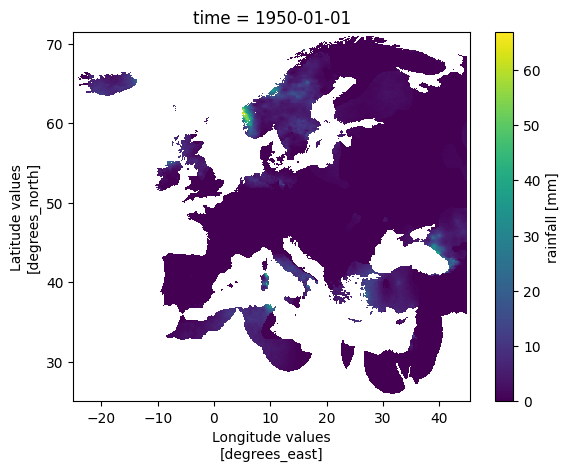

In [5]:
import xarray as xr

# Load the .nc file
data = xr.open_dataset(r"c:\ThesisData\EOBS\RainFallMeanEnsemble\rr_ens_mean_0.1deg_reg_v30.0e.nc")

# Inspect the structure of the file
print(data)

import matplotlib.pyplot as plt

# Quick plot (e.g., for 2D data)
variable = data["rr"].isel(time=0)
variable.plot()
#So my variable begins healthy

## 🧩 Function Corpus

In this section, I define my python functions for later use. All functions are well-documented with descriptions, and examples are provided for each function to illustrate how they work.

### 🛠️ Section 1: Masking Functions

This section contains specialized functions for cropping space-time datacubes, either in time, space, or both. These functions are essential for handling smaller datasets and making data manipulation more efficient.

I need to improve those masking functions with CDO, generalizing spheres with ellipsoids

In [6]:

def mask_rectangle(ds, center, side_length=None, width=None, height=None):
    """
    Masks the dataset to include only points within a specified rectangular or square region.

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing latitude and longitude data.
    center (tuple): A tuple of coordinates (longitude, latitude) representing the center of the rectangle.
    side_length (float, optional): If specified, sets both width and height to create a square.
    width (float, optional): The width of the rectangle in kilometers (longitude range). Defaults to side_length.
    height (float, optional): The height of the rectangle in kilometers (latitude range). Defaults to side_length.

    Returns:
    xarray.Dataset: A new xarray dataset containing only the points within the specified rectangle or square.
    """
    # Default to a square if side_length is provided
    if side_length is not None:
        width = height = side_length
    if width is None or height is None:
        raise ValueError("Either 'side_length' or both 'width' and 'height' must be specified.")

    # Calculate half dimensions
    half_width = width / 2
    half_height = height / 2

    # Define the boundaries of the rectangle
    min_lon = center[0] - half_width
    max_lon = center[0] + half_width
    min_lat = center[1] - half_height
    max_lat = center[1] + half_height

    # Apply the mask to select points within the rectangle
    masked_ds = ds.where(
        (ds['lon'] > min_lon) & (ds['lon'] < max_lon) &
        (ds['lat'] > min_lat) & (ds['lat'] < max_lat),
        drop=True
    )
    return masked_ds


def mask_square_true(ds, center, half_side_km):
    """
    Select a square region on the sphere based on true distances using geodesic calculations.

    Parameters:
    ds (xarray.Dataset): The dataset containing 'lat' and 'lon' coordinates.
    center (tuple): The (longitude, latitude) of the center point.
    half_side_km (float): Half the side length of the square in kilometers.

    Returns:
    xarray.Dataset: A new dataset with points within the spherical square.
    """
    # Initialize geodesic calculator
    geod = Geod(ellps="WGS84")
    lon_center, lat_center = center

    # Precompute geodesic bounds for the square
    bounds = geod.fwd(
        [lon_center] * 4, [lat_center] * 4, [0, 180, 90, 270], [half_side_km * 1000] * 4
    )
    lat_min, lat_max = sorted([bounds[1][0], bounds[1][1]])
    lon_min, lon_max = sorted([bounds[0][2], bounds[0][3]])

    # Efficiently create a mask using xarray's broadcasting
    mask = (ds['lat'] >= lat_min) & (ds['lat'] <= lat_max) & (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)

    # Apply the mask directly to the dataset
    return ds.where(mask, drop=True)

def mask_sphere_true(ds, center, radius_km):
    """
    Select points within a specified geodesic radius from a central point in an xarray dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing 'lat' and 'lon' coordinates.
    center (tuple): The (longitude, latitude) of the center point.
    radius_km (float): The radius of the spherical selection in kilometers.

    Returns:
    xarray.Dataset: A new dataset with points within the spherical selection.
    """
    # Initialize geodesic calculator with WGS84 ellipsoid
    geod = Geod(ellps="WGS84")
    lon_center, lat_center = center

    # Extract 1D coordinate arrays from the dataset
    lon = ds['lon'].values
    lat = ds['lat'].values

    # Create 2D coordinate grids
    lon_2d, lat_2d = np.meshgrid(lon, lat)

    # Compute geodesic distances in a vectorized manner
    _, _, dist = geod.inv(lon_center, lat_center, lon_2d, lat_2d)

    # Create a mask for points within the radius (convert radius to meters)
    mask = dist <= radius_km * 1000

    # Create a DataArray for the mask with appropriate coordinates and dimensions
    mask_da = xr.DataArray(mask, coords={"lat": ds["lat"], "lon": ds["lon"]}, dims=["lat", "lon"])

    # Apply the mask to the dataset, dropping points outside the radius
    masked_ds = ds.where(mask_da, drop=True)

    return masked_ds

def mask_time(ds, season='summer'):
    """
    Mask the dataset to include only specific seasons, such as summer (April to September) or winter (October to March).

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing a time dimension with cftime objects.
    season (str, optional): The season to mask. Supports 'summer' (April to September) or 'winter' (October to March). Default is 'summer'.

    Returns:
    xarray.Dataset: A new xarray dataset containing only the specified season.

    Example usage:
    ds_summer = mask_time(datacube, season='summer')
    ds_winter = mask_time(datacube, season='winter')
    """
    if season == 'summer':
        ds = ds.sel(time=[t for t in ds['time'].values if t.month in [4, 5, 6, 7, 8, 9]])
    elif season == 'winter':
        ds = ds.sel(time=[t for t in ds['time'].values if t.month in [10, 11, 12, 1, 2, 3]])
    else:
        raise ValueError("Supported seasons are 'summer' and 'winter'.")
    return ds

In [9]:
test = load_netcdf(filepath=r"c:\ThesisData\EOBS\RainFallMeanEnsemble\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude'))
test


---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[1], line 1
----> 1 test = load_netcdf(filepath=r"c:\ThesisData\EOBS\RainFallMeanEnsemble\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude'))
      2 test

NameError: name 'load_netcdf' is not defined


Error: NameError

In [7]:
center = (7.0, 50.5) # Longitude, Latitude
radius_km = 200  # 100 km radius
spherical_ds = mask_square_true(test, center, radius_km)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[1], line 3
      1 center = (7.0, 50.5) # Longitude, Latitude
      2 radius_km = 200  # 100 km radius
----> 3 spherical_ds = mask_square_true(test, center, radius_km)

NameError: name 'test' is not defined


Error: NameError

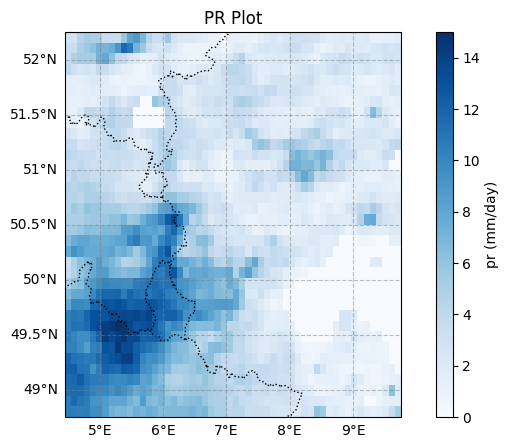

In [19]:
plot_datacube(spherical_ds.dropna(dim="lon").isel(time=888))
print(spherical_ds)
for d in ['time', 'lat', 'lon']:
    my_ds = spherical_ds.dropna(dim=d, how='any', subset=['pr'])
plot_datacube(spherical_ds.dropna(dim="lon").isel(time=888))

In [8]:
def xarray_to_endog_exog(ds: xr.Dataset,
                         endog_var: str,
                         include_space_coords: bool = True,
                         include_time_coords: bool = True
                         ) -> tuple[np.ndarray, np.ndarray, dict]:
    """
    Transform an xarray Dataset into NumPy arrays: endog and exog, plus metadata.

    Reshapes data from grid dimensions ('time', 'lat', 'lon') into ('time', 'space')
    or ('time', 'covariates', 'space') formats suitable for some modeling approaches.

    Parameters:
    -----------
    ds : xr.Dataset
        The input xarray Dataset with dimensions 'time', 'lat', 'lon' and
        data variables that may depend on one or more of these dimensions.
    endog_var : str
        The name of the data variable to be used as the endogenous variable.
        Must have dimensions ('time', 'lat', 'lon').
    include_space_coords : bool, optional (default=True)
        Whether to include 'lat' and 'lon' coordinates as covariates in the exog array.
    include_time_coords : bool, optional (default=False)
        Whether to include the 'time' coordinate as a covariate in the exog array.
        If True, the time coordinate value for each time step is repeated across
        all spatial locations for that step.

    Returns:
    --------
    tuple[np.ndarray, np.ndarray, dict]
        - endog: NumPy array of shape (t, s) representing the endogenous variable.
                 s = n_lat * n_lon is the total number of spatial locations.
        - exog: NumPy array of shape (t, c, s) representing the exogenous variables.
                c is the number of covariates.
        - metadata: Dictionary with keys:
            - 't': Number of time steps.
            - 'n_lat': Number of latitude points.
            - 'n_lon': Number of longitude points.
            - 's': Total number of spatial points (n_lat * n_lon).
            - 'covariates': List of dicts, each with 'name', 'original_dims',
                            and 'is_coord' for each exog covariate.

    Raises:
    -------
    ValueError
        If 'endog_var' is not found or does not have the required dimensions ('time', 'lat', 'lon').
        If a data variable has unsupported dimensions.
        If no exogenous variables are generated.
    KeyError
        If required dimensions 'time', 'lat', or 'lon' are missing from the dataset.
    """
    # Extract dimension sizes and validate required dimensions
    try:
        t = len(ds['time'])
        n_lat = len(ds['lat'])
        n_lon = len(ds['lon'])
    except KeyError as e:
        raise KeyError(f"Dataset is missing required dimension: {e}. Expected 'time', 'lat', 'lon'.")

    s = n_lat * n_lon  # Total number of spatial locations

    # Validate endog_var
    if endog_var not in ds.data_vars:
        raise ValueError(f"Endogenous variable '{endog_var}' not found in dataset.")
    if set(ds[endog_var].dims) != {'time', 'lat', 'lon'}:
        raise ValueError(f"Endogenous variable '{endog_var}' must have dimensions ('time', 'lat', 'lon'). Found {ds[endog_var].dims}")

    # Extract endog: stack spatial dimensions
    # Ensure the stacking order ('lat', 'lon') matches flattening below
    endog = ds[endog_var].stack(space=('lat', 'lon')).values  # Shape: (t, s)

    # Initialize list for exog covariates and metadata
    exog_list = []
    covariates_metadata = []

    # Include spatial covariates (lat and lon) if requested
    if include_space_coords:
        # Create meshgrid - 'ij' indexing ensures shape (n_lat, n_lon)
        lat_mesh, lon_mesh = np.meshgrid(ds['lat'].values, ds['lon'].values, indexing='ij')
        # Flatten in C-order (row-major), consistent with stack('lat', 'lon')
        lat_flat = lat_mesh.flatten()  # Shape: (s,)
        lon_flat = lon_mesh.flatten()  # Shape: (s,)
        # Repeat the spatial pattern for each time step
        lat_repeated = np.repeat(lat_flat[None, :], t, axis=0)  # Shape: (t, s)
        lon_repeated = np.repeat(lon_flat[None, :], t, axis=0)  # Shape: (t, s)

        exog_list.extend([lat_repeated, lon_repeated])
        covariates_metadata.append({'name': 'lat', 'original_dims': ('lat',), 'is_coord': True})
        covariates_metadata.append({'name': 'lon', 'original_dims': ('lon',), 'is_coord': True})

    # Include time coordinate if requested
    if include_time_coords:
        # Index of each time step: 0, 1, …, t-1  ➊
        time_index = np.arange(t, dtype=float)             # shape (t,)

        # Broadcast to every spatial location  ➋
        time_repeated = np.repeat(time_index[:, None], s, axis=1)  # (t, s)

        exog_list.append(time_repeated)
        covariates_metadata.append(
            {
                "name": "time_index_0_to_N",
                "original_dims": ("time",),
                "is_coord": True,
            }
        )


    # Process each data variable (potential exogenous covariates) except endog_var
    for var in ds.data_vars:
        if var == endog_var:
            continue

        var_data = ds[var]
        dims = var_data.dims
        data = var_data.values
        original_dims_tuple = tuple(dims) # Store original dims for metadata

        # Reshape/broadcast based on original dimensions
        if set(dims) == {'time', 'lat', 'lon'}:
            # Already has all dims, just stack space
            var_stacked = var_data.stack(space=('lat', 'lon')).values  # Shape: (t, s)
            exog_list.append(var_stacked)
        elif set(dims) == {'lat', 'lon'}:
            # Spatial only, flatten and repeat over time
            var_flat = data.reshape(s) # Flatten assuming 'lat' then 'lon' order
            var_broadcast = np.repeat(var_flat[None, :], t, axis=0)  # Shape: (t, s)
            exog_list.append(var_broadcast)
        elif len(dims) == 1:
            # Single dimension, broadcast appropriately
            if dims[0] == 'time':
                # Time only, repeat over space
                var_broadcast = np.repeat(data[:, None], s, axis=1)  # Shape: (t, s)
                exog_list.append(var_broadcast)
            elif dims[0] == 'lat':
                # 'lat' only, tile across 'lon', flatten, repeat over time
                var_tiled = np.tile(data[:, None], (1, n_lon)).flatten() # Shape: (s,)
                var_broadcast = np.repeat(var_tiled[None, :], t, axis=0) # Shape: (t, s)
                exog_list.append(var_broadcast)
            elif dims[0] == 'lon':
                 # 'lon' only, tile across 'lat', flatten, repeat over time
                 var_tiled = np.tile(data[None, :], (n_lat, 1)).flatten() # Shape: (s,)
                 var_broadcast = np.repeat(var_tiled[None, :], t, axis=0) # Shape: (t, s)
                 exog_list.append(var_broadcast)
            else:
                 # Unsupported single dimension name
                 raise ValueError(f"Variable '{var}' has unsupported single dimension: {dims[0]}. Expected 'time', 'lat', or 'lon'.")
        elif len(dims) == 0: # Scalar variable
            # Broadcast scalar to all points in time and space
            var_broadcast = np.full((t, s), data.item()) # Shape: (t, s)
            exog_list.append(var_broadcast)
        else:
            # Any other dimension combination is unsupported
            raise ValueError(f"Variable '{var}' has unsupported dimensions: {dims}. Expected combinations of ('time', 'lat', 'lon') or scalar.")

        # Add metadata for this processed variable if it was added
        if var not in [m['name'] for m in covariates_metadata]: # Avoid duplicates if somehow processed differently
             covariates_metadata.append({'name': var, 'original_dims': original_dims_tuple, 'is_coord': False})


    # Stack all prepared exog covariates into the final exog array
    if not exog_list:
        # Raise error only if *no* covariates were generated at all
        raise ValueError("No exogenous variables generated. Ensure include_space_coords/include_time_coords is True or add suitable data variables.")

    # Stack along a new 'covariate' dimension (axis=1)
    exog = np.stack(exog_list, axis=1)  # Shape: (t, c, s)

    # Compile final metadata
    metadata = {
        't': t,
        'n_lat': n_lat,
        'n_lon': n_lon,
        's': s,
        'covariates': covariates_metadata
    }

    return endog, exog, metadata

def endog_exog_to_xarray(endog: np.ndarray, exog: np.ndarray, endog_var: str, metadata: dict) -> xr.Dataset:
    """
    Transform endog and exog NumPy arrays back into an xarray Dataset using metadata.

    Parameters:
    -----------
    endog : np.ndarray
        The endogenous variable array of shape (t, s).
    exog : np.ndarray
        The exogenous variables array of shape (t, c, s).
    endog_var : str
        The name of the endogenous variable.
    metadata : dict
        Metadata from xarray_to_endog_exog with 't', 'n_lat', 'n_lon', and 'covariates'.

    Returns:
    --------
    xr.Dataset
        The reconstructed xarray Dataset with dimensions 'time', 'lat', 'lon'.

    Raises:
    -------
    ValueError
        If the shapes of endog or exog do not match the metadata dimensions.
        If the number of covariates in exog does not match metadata.
    """
    # Extract metadata
    t = metadata['t']
    n_lat = metadata['n_lat']
    n_lon = metadata['n_lon']
    s = n_lat * n_lon
    covariates = metadata['covariates']

    # Validate input shapes
    if endog.shape != (t, s):
        raise ValueError(f"endog must have shape ({t}, {s}), got {endog.shape}")
    if exog.shape != (t, len(covariates), s):
        raise ValueError(f"exog must have shape ({t}, {len(covariates)}, {s}), got {exog.shape}")

    # Initialize coordinate arrays
    time = np.arange(t)
    lat = None
    lon = None

    # Extract lat and lon from exog where is_coord=True
    for i, cov in enumerate(covariates):
        if cov['is_coord']:
            data = exog[:, i, :]
            if cov['name'] == 'lat':
                # Take the first time slice and reshape to original lat array
                lat = data[0, :].reshape(n_lat, n_lon)[:, 0]  # Extract unique lat values
            elif cov['name'] == 'lon':
                # Take the first time slice and reshape to original lon array
                lon = data[0, :].reshape(n_lat, n_lon)[0, :]  # Extract unique lon values

    if lat is None or lon is None:
        raise ValueError("Latitude or longitude coordinates not found in exog covariates.")

    # Reshape endog back to (t, n_lat, n_lon)
    endog_reshaped = endog.reshape(t, n_lat, n_lon)

    # Initialize the dataset with the endogenous variable and original coordinates
    ds = xr.Dataset(
        {endog_var: (['time', 'lat', 'lon'], endog_reshaped)},
        coords={'time': time, 'lat': lat, 'lon': lon}
    )

    # Reconstruct exogenous variables (excluding coordinates)
    for i, cov in enumerate(covariates):
        if cov['is_coord']:
            continue  # Skip lat and lon as they’re already in coords
        name = cov['name']
        dims = cov['dims']
        data = exog[:, i, :]

        if set(dims) == {'time', 'lat', 'lon'}:
            ds[name] = (['time', 'lat', 'lon'], data.reshape(t, n_lat, n_lon))
        elif set(dims) == {'lat', 'lon'}:
            ds[name] = (['lat', 'lon'], data[0].reshape(n_lat, n_lon))
        elif len(dims) == 1:
            if dims[0] == 'time':
                ds[name] = (['time'], data[:, 0])
            elif dims[0] == 'lat':
                ds[name] = (['lat'], data[0].reshape(n_lat, n_lon).mean(axis=1))
            elif dims[0] == 'lon':
                ds[name] = (['lon'], data[0].reshape(n_lat, n_lon).mean(axis=0))
        else:
            raise ValueError(f"Unsupported dimensions for variable '{name}': {dims}")
            
    return ds
# Example usage:
endog, exog, metadata = xarray_to_endog_exog(ds=ds, include_space_coords=True, endog_var="pr")
ds_reconstructed = endog_exog_to_xarray(endog, exog, "pr", metadata)

Synthetic one

In [7]:
def generate_gevd_precip_dataset(
    lat_start: float = 1,
    lat_end: float = 10,
    lat_res: float = 0.25,
    lon_start: float = 1,
    lon_end: float = 10,
    lon_res: float = 0.25,
    start: str = "1900-12-31",
    periods: int = 100,
    freq: str = "YE",
    gev_shape: float = 0.1,
    gev_scale: float = 5,
    base_loc: float = 26,
    loc_time_slope: float = 0,
    sigma: float = 2.0,  # isotropic range parameter
    seed: int = 42,
):
    """
    Generate a synthetic precipitation‑maxima ``xarray.Dataset`` with **isotropic** (circular)
    spatial modulation of the GEV location parameter.

    Parameters
    ----------
    lat_start, lat_end : float
        Latitude bounds (degrees).
    lat_res            : float
        Latitude resolution (grid spacing, degrees).
    lon_start, lon_end : float
        Longitude bounds (degrees).
    lon_res            : float
        Longitude resolution (grid spacing, degrees).
    start              : str or pandas‑compatible datetime
        Start date for the ``time`` coordinate.
    periods            : int
        Number of time steps.
    freq               : str
        Pandas offset alias (e.g., "A" for annual, "M" monthly, "D" daily).
    gev_shape          : float
        Shape parameter (c) for the GEV distribution.
    gev_scale          : float
        Scale parameter (σ) for the GEV distribution.
    base_loc           : float
        Baseline location parameter (μ) for the GEV distribution.
    loc_time_slope     : float
        Linear trend added to the location parameter each time step.
    sigma              : float
        Range parameter controlling the spatial radius of the circular Gaussian weight.
    seed               : int
        Random seed for reproducibility.

    Returns
    -------
    xr.Dataset
        Dataset with one DataArray named ``pr`` of shape (time, lat, lon).
    """

    rng = np.random.default_rng(seed)

    # Coordinate arrays
    lats = np.arange(lat_start, lat_end + 1e-9, lat_res)
    lons = np.arange(lon_start, lon_end + 1e-9, lon_res)
    times = pd.date_range(start=start, periods=periods, freq=freq)

    # Meshgrid for spatial coordinates
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    # Centre of the domain
    lon_c = 0.5 * (lon_start + lon_end)
    lat_c = 0.5 * (lat_start + lat_end)

    # Radial distance from centre
    r2 = (lon_grid - lon_c) ** 2 + (lat_grid - lat_c) ** 2

    # Isotropic (circular) Gaussian weight field
    weight = np.exp(-r2 / sigma ** 2)

    # Baseline spatial pattern for the GEV location parameter
    loc_grid0 = base_loc + 30 * weight  # up to +10 mm/day boost at the centre
    print(loc_grid0)
    # Allocate precipitation array (time, lat, lon)
    precip = np.empty((periods, len(lats), len(lons)), dtype=np.float32)

    for t in range(periods):
        # Time‑varying location parameter with optional linear trend
        loc_grid = loc_grid0 + loc_time_slope * t
        precip[t, :, :] = genextreme.rvs(
            c=-0.3,  # scipy uses negative sign convention
            loc=loc_grid,
            scale=5,
            random_state=rng,
        )

    da = xr.DataArray(
        precip,
        coords={"time": times, "lat": lats, "lon": lons},
        dims=("time", "lat", "lon"),
        name="pr",
        attrs={
            "long_name": "Synthetic precipitation maxima (GEV, circular modulation)",
            "units": "mm",
            "source": "Procedurally generated by generate_gevd_precip_dataset()",
        },
    )

    return xr.Dataset({"pr": da})


# Generate the dataset
ds = generate_gevd_precip_dataset(periods=100, freq="A", loc_time_slope=0.5)

# Recreate and save the figures
for i, t in enumerate((0, 99)):
    da = ds.pr.isel(time=t)
    q99 = da.quantile(0.99)
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    im = da.plot(
        ax=ax,
        cmap="Blues",
        vmax=q99,
        add_colorbar=True,
        cbar_kwargs={'label': 'Precipitation (mm)'}
    )
    ax.set_title(f"Synthetic Precipitation Maxima (Year {t})", fontsize=16)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.tick_params(labelsize=10)
    fig.savefig(f"c:/Users/paulusr/Documents/SavedFigures/synth_{i}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close to free memory

C:\Users\paulusr\AppData\Local\Temp\ipykernel_16260\2715757242.py:62: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  times = pd.date_range(start=start, periods=periods, freq=freq)


[[26.00120196 26.0020768  26.00347798 ... 26.00347798 26.0020768
  26.00120196]
 [26.0020768  26.00358839 26.00600942 ... 26.00600942 26.00358839
  26.0020768 ]
 [26.00347798 26.00600942 26.01006388 ... 26.01006388 26.00600942
  26.00347798]
 ...
 [26.00347798 26.00600942 26.01006388 ... 26.01006388 26.00600942
  26.00347798]
 [26.0020768  26.00358839 26.00600942 ... 26.00600942 26.00358839
  26.0020768 ]
 [26.00120196 26.0020768  26.00347798 ... 26.00347798 26.0020768
  26.00120196]]


In [45]:
exog.shape

(75, 3, 1369)

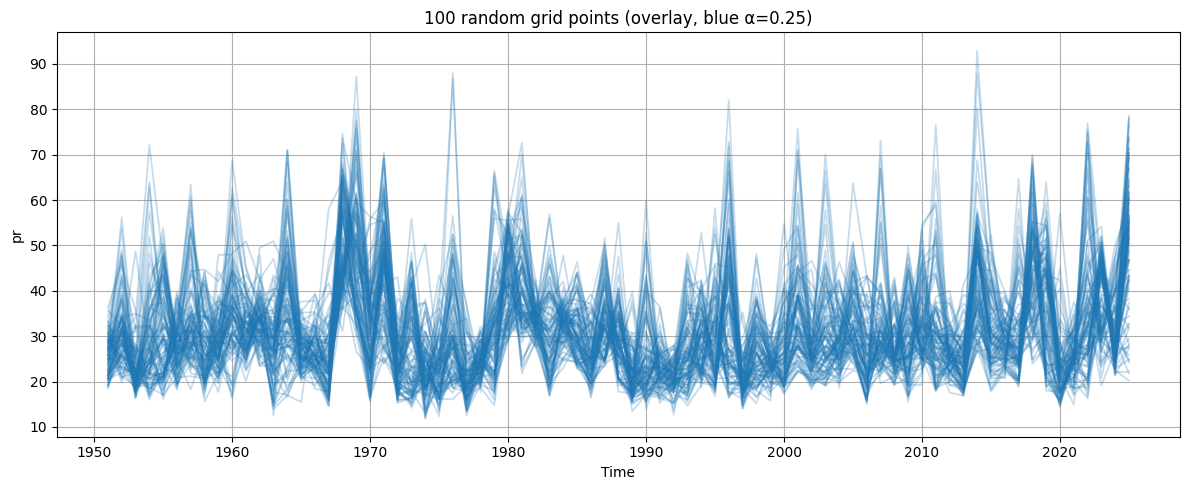

In [12]:
import matplotlib.dates as mdates

def plot_pr_timeseries(ds, n=9, mode="overlay", col_wrap=3, seed=None,
                       alpha=0.25):
    """
    Plot `n` precipitation time-series from (time, lat, lon) data.

    Parameters
    ----------
    ds     : xr.Dataset | xr.DataArray   (needs 'pr(time, lat, lon)')
    n      : int      – number of grid points to plot
    mode   : "overlay" | "facet"
    col_wrap : int    – columns per row when mode="facet"
    seed   : int | None – RNG seed for reproducible random picks
    alpha  : float [0-1] – opacity of lines in overlay mode
    """
    da = ds["pr"] if isinstance(ds, xr.Dataset) else ds
    pts = da.stack(pt=("lat", "lon"))

    rng = np.random.default_rng(seed)
    if n > pts.pt.size:
        raise ValueError(f"`n` ({n}) exceeds grid size ({pts.pt.size}).")
    sel = pts.isel(pt=rng.choice(pts.pt.size, n, replace=False))

    if mode == "facet":
        sel.plot.line(
            x="time", col="pt", col_wrap=col_wrap, color="tab:blue",
            linewidth=1.0, figsize=(4 * col_wrap,
            3 * ((n + col_wrap - 1) // col_wrap)),
        )
        plt.suptitle(f"{n} random grid points", y=1.02)

    elif mode == "overlay":
        fig, ax = plt.subplots(figsize=(12, 5))

        time_num = mdates.date2num(sel["time"].values)
        for p in sel.pt.values:
            y = sel.sel(pt=p).values
            ax.plot(time_num, y, color="tab:blue", alpha=alpha, lw=1.3)

        ax.xaxis_date()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.set_xlabel("Time")
        ax.set_ylabel("pr")
        ax.set_title(f"{n} random grid points (overlay, blue α={alpha})")
        ax.grid(True)

    else:
        raise ValueError("`mode` must be 'overlay' or 'facet'.")

    plt.tight_layout()
    plt.show()



plot_pr_timeseries(EOBS_blockmax_grid, n=100, mode="overlay", seed=42) 

Make the space-time fit to test endog-exog unwrapping used for weights later on. 
Roadmap : 1) Turn (S,3) --> into xarray (lat, lon , 3)
Make Simulated data of the xarray classic type where we known mu, sigma and xi and we set mu to change in space and time
Compute return level curve for a specific space_time location at T[given]
Compare complete model RL curve to true model RL curve. 

What I get : DATA PLOT (done for PP presentation will change maybe during next week)
RL plot NS gev (DONE, just a matter of running it)
RL plot using 1) 

--- Depends on simulations ---- 
Weight PLOT (Mostly done has to tweak it a bit to incorporate cartopy)
RL plot 1 (alone), RL plot 2 (weighted), RL plot 3 (full). All with CI and compared to true RL. 

5.5
nearest s0 = 684 at (lat, lon) = (5.5, 5.5)
(100, 1369)
[[1.70201586e-36 1.35207867e-34 8.36501451e-33 ... 8.36501451e-33
  1.35207867e-34 1.70201586e-36]
 [1.74922784e-36 1.38958379e-34 8.59705051e-33 ... 8.59705051e-33
  1.38958379e-34 1.74922784e-36]
 [1.79725013e-36 1.42773262e-34 8.83306895e-33 ... 8.83306895e-33
  1.42773262e-34 1.79725013e-36]
 ...
 [6.63598951e-36 5.27161942e-34 3.26143545e-32 ... 3.26143545e-32
  5.27161942e-34 6.63598951e-36]
 [6.63875509e-36 5.27381639e-34 3.26279466e-32 ... 3.26279466e-32
  5.27381639e-34 6.63875509e-36]
 [6.63967720e-36 5.27454891e-34 3.26324786e-32 ... 3.26324786e-32
  5.27454891e-34 6.63967720e-36]]


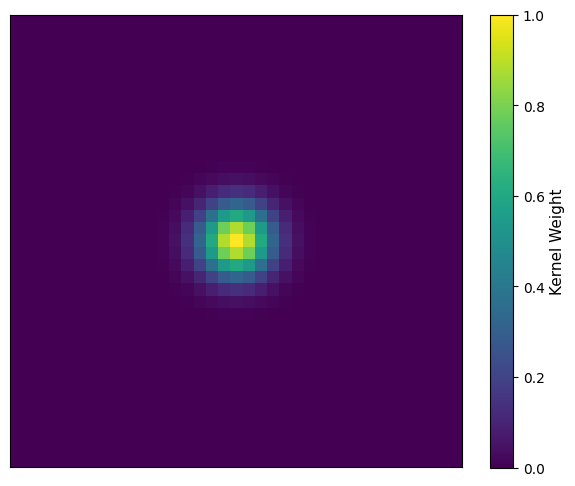

In [24]:
# -----------------------------------------------------------
# 1. flatten
# -----------------------------------------------------------
pr_stacked = ds["pr"].stack(space=("lat", "lon")).transpose("time", "space")
lat_vec  = pr_stacked["lat"].values           # (s,)
lon_vec  = pr_stacked["lon"].values           # (s,)
nlat = len(np.unique(lat_vec))
nlon = len(np.unique(lon_vec))
lat_vals = np.sort(np.unique(lat_vec))
lon_vals = np.sort(np.unique(lon_vec))
time_cf  = ds["time"].values 
N         = len(time_cf)                        # total number of records
time_num  = np.arange(1, N + 1, dtype=np.int32)                  # array of cftime.DatetimeGregorian
t, s     = pr_stacked.sizes["time"], pr_stacked.sizes["space"]

# -----------------------------------------------------------
# 2.  Reference point  (middle of space, *last* time step)
# -----------------------------------------------------------
lat0 = lat_vals[len(np.unique(ds.lat)) // 2] 
print(lat0)  # spatial centre
lon0 = lon_vec[len(np.unique(ds.lon)) // 2]
t0   = time_num[-1]                           # ***last*** record
dist2 = (lat_vec - lat0)**2 + (lon_vec - lon0)**2      # squared distance
s0    = int(np.argmin(dist2))                          # index of min dist
print("nearest s0 =", s0,
      "at (lat, lon) =", (lat_vec[s0], lon_vec[s0]))

# -----------------------------------------------------------
# 3.  Kernel(s) & bandwidths (examples)
# -----------------------------------------------------------
def gaussian(u):
    return np.exp(-0.5 * u * u)

# spatial bandwidth: one grid step (median spacing)
grid_spacing = np.min(
    np.sqrt((lat_vec[None,:]-lat_vec[:,None])**2 +
            (lon_vec[None,:]-lon_vec[:,None])**2) + np.eye(len(lat_vec))*1e9
)
h_s = 2*grid_spacing
# temporal bandwidth: 10 % of total record length (days)
h_t = 60

# -----------------------------------------------------------
# 4.  Weight matrix  w  ∈ ℝ^(t × s)
# -----------------------------------------------------------
lat_0 = 49.5
d_space = np.sqrt((lat_vec - lat0)**2 + (lon_vec - lon0)**2)   # (s,)
d_time  = np.abs(time_num - t0)                                # (t,)

K_s = gaussian(d_space / h_s)          # (s,)
K_t = gaussian(d_time  / h_t)          # (t,)

weights = (K_t[:, None] * K_s[None, :]) # (t, s)
print(weights.shape)   # (75, 100)  — matches your endog
print(weights)

# reshape slice at last time
weight_grid = weights[-1].reshape(nlat, nlon)

fig, ax = plt.subplots(figsize=(6, 5))
extent = [lon_vals[0], lon_vals[-1], lat_vals[0], lat_vals[-1]]
img = ax.imshow(weight_grid, origin='lower', extent=extent, aspect='equal')

# Colorbar with label
cbar = plt.colorbar(img, ax=ax, label="Kernel Weight")

# Clear, concise title
ax.set_title("")

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])

# Optional: Add a grid if useful for interpreting
# ax.grid(True, color='gray', alpha=0.2)

plt.tight_layout()

# Save at 300 DPI
plt.savefig(r"c:\Users\paulusr\Documents\SavedFigures\weight1", dpi=300)
plt.show()

In [32]:
exog.shape

(100, 3, 1369)


          EVT Results Summary       
Data dimensions : (100, 1)
AIC: 14.42  
BIC: 24.84  

+------------+--------------+--------------+--------------+---------------------------+----------+
| Parameter  | Estimate     | Z-score      | P>|Z-score|  | 95% CI                    | Signif   |
+------------+--------------+--------------+--------------+---------------------------+----------+
| μ_0        | 55.7563      | 63.26        | 0.0000       | (54.0288, 57.4838)        | ***      |
| μ_1        | 0.5004       | 34.83        | 0.0000       | (0.4723, 0.5286)          | ***      |
| σ_0        | 4.5569       | 10.90        | 0.0000       | (3.7376, 5.3761)          | ***      |
| ξ_0        | 0.2023       | 2.28         | 0.0229       | (0.0280, 0.3766)          | *        |
+------------+--------------+--------------+--------------+---------------------------+----------+
Significance : *** p<0.001, ** p<0.01, * p<0.05



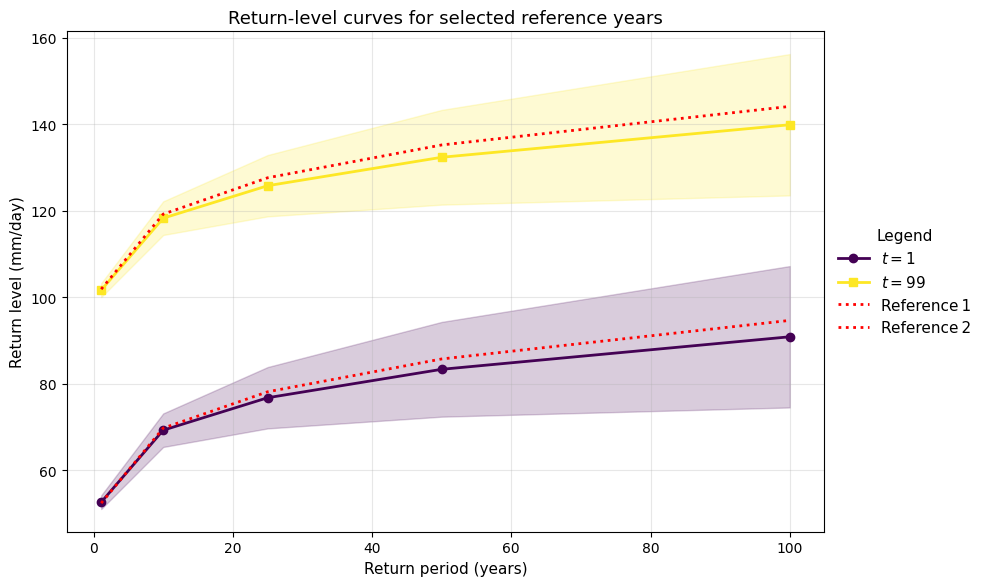

In [45]:
EOBS = pd.read_csv(r"c:\ThesisData\EOBS\Blockmax\blockmax_temp.csv")
manual_params = np.array([
    [56.0,  4.6, 0.24],   # μ, σ, ξ for t = 0
    [105.5, 4.6, 0.24],   # μ, σ, ξ for t = 99
]).T  

#afit_noweight = GEVSample(endog=endog[:,:],exog={"location" : exog[:,1:3,:]}).fit(fit_method='MLE')
#print(afit_noweight)
#print(afit_noweight.return_level(T=[10,20,35,50,100,200,250],t=[0,25,50,74]).level_plot())
afit_weight = GEVSample(endog=endog[:,684],exog={"location" : exog[:,2,684]}).fit(fit_method='MLE')
print(afit_weight)
afit_weight.return_level(T=[1.1,10,25,50,100], t=[1,99]).time_plot(manual_params=manual_params,save_path=r"C:\Users\paulusr\Documents\SavedFigures\RLF1")
#print(afit_weight.return_level(T=[10,50,100,200,250],t=[0,25,50,74]).time_plot(s=55))


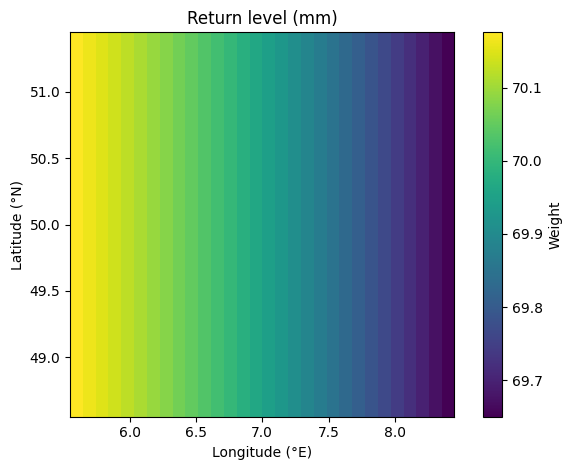

In [108]:
fig, ax = plt.subplots()
extent = [lon_vals[0], lon_vals[-1], lat_vals[0], lat_vals[-1]]
img = ax.imshow(a, origin='lower', extent=extent, aspect='equal')

plt.colorbar(img, ax=ax, label="Weight")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_title("Return level (mm)")
plt.tight_layout()
plt.show()

Define the weights based on the space-time kernel.

In [294]:
def gev_return_level_vec(params, T, eps=1e-8):
    """
    Vectorised GEV return levels.

    Parameters
    ----------
    params : array-like, shape (t, 3)
        Columns are μ, σ, ξ for each time step t.
    T : array-like, shape (T,)
        Return periods (> 1).  A list or 1-D NumPy array is fine.
    eps : float, optional
        Threshold below which |ξ| is treated as zero (Gumbel limit).

    Returns
    -------
    z : ndarray, shape (len(T), t)
        Return levels.  Row i corresponds to T[i]; column j to time j.
    """
    params = np.asarray(params, dtype=float)
    if params.ndim != 2 or params.shape[1] != 3:
        raise ValueError("`params` must be a (t, 3) array: columns = μ, σ, ξ.")

    mu, sigma, xi = params.T          # each shape (t,)
    T   = np.asarray(T, dtype=float)
    if (T <= 1).any():
        raise ValueError("All return periods must be > 1.")

    # Broadcast to 2-D (T, t)
    y     = -np.log1p(-1.0 / T)[:, None]   # shape (T,1)
    mu_b  = mu[None, :]                    # shape (1,t)
    sig_b = sigma[None, :]
    xi_b  = xi[None, :]

    # Gumbel versus general GEV
    gumbel = np.abs(xi_b) < eps
    z = np.empty_like(mu_b * y)            # allocate (T,t)

    z[gumbel]  = mu_b[gumbel]  - sig_b[gumbel] * np.log(y[gumbel])
    z[~gumbel] = mu_b[~gumbel] + (sig_b[~gumbel] / xi_b[~gumbel]) * (
                     y[~gumbel]**(-xi_b[~gumbel]) - 1.0)

    return z
    
params = np.array([
    [35.0, 5.0, -0.25],   # t = 0
    [35.5, 5.0, -0.25],   # t = 1
    [37.5, 5.0, -0.25],   # t = 25
    [40.0, 5.0, -0.25],   # t = 50
])

T = [10, 23, 50, 100, 150, 200]

z = gev_return_level_vec(params, T)   # shape (6,4)

print(z)

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[1], line 53
     44 params = np.array([
     45     [35.0, 5.0, -0.25],   # t = 0
     46     [35.5, 5.0, -0.25],   # t = 1
     47     [37.5, 5.0, -0.25],   # t = 25
     48     [40.0, 5.0, -0.25],   # t = 50
     49 ])
     51 T = [10, 23, 50, 100, 150, 200]
---> 53 z = gev_return_level_vec(params, T)   # shape (6,4)
     55 print(z)

Cell In[1], line 38, in gev_return_level_vec(params, T, eps)
     35 gumbel = np.abs(xi_b) < eps
     36 z = np.empty_like(mu_b * y)            # allocate (T,t)
---> 38 z[gumbel]  = mu_b[gumbel]  - sig_b[gumbel] * np.log(y[gumbel])
     39 z[~gumbel] = mu_b[~gumbel] + (sig_b[~gumbel] / xi_b[~gumbel]) * (
     40                  y[~gumbel]**(-xi_b[~gumbel]) - 1.0)
     42 return z

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6 but corresponding boolean di

Error: IndexError

In [21]:
def create_return_level_dataset_with_ci(estimates, lower_bounds, upper_bounds, lat, lon, time_array, return_periods):
    """
    Create an xarray.Dataset with return levels and confidence intervals for a single model.
    
    Parameters:
    -----------
    estimates : numpy.ndarray
        Return level estimates, shape (T, t, s).
    lower_bounds : numpy.ndarray
        Lower CI bounds, shape (T, t, s).
    upper_bounds : numpy.ndarray
        Upper CI bounds, shape (T, t, s).
    lat : numpy.ndarray
        Latitude coordinates, length nlat.
    lon : numpy.ndarray
        Longitude coordinates, length nlon.
    time_array : numpy.ndarray
        Time points, length t.
    return_periods : numpy.ndarray
        Return periods, length T.
    
    Returns:
    --------
    xarray.Dataset
        Dataset with one variable 'return_level' of shape (T, t, nlat, nlon, 3).
    """
    # Extract dimensions
    T, t, s = estimates.shape
    nlat, nlon = len(lat), len(lon)
    
    # Validate inputs
    if s != nlat * nlon:
        raise ValueError(f"s dimension ({s}) must equal nlat * nlon ({nlat * nlon})")
    if lower_bounds.shape != estimates.shape or upper_bounds.shape != estimates.shape:
        raise ValueError("estimates, lower_bounds, and upper_bounds must have the same shape")
    if len(time_array) != t:
        raise ValueError("time_array length must match t dimension")
    if len(return_periods) != T:
        raise ValueError("return_periods length must match T dimension")
    
    # Reshape each array from (T, t, s) to (T, t, nlat, nlon)
    est_reshaped = estimates.reshape(T, t, nlat, nlon)
    lower_reshaped = lower_bounds.reshape(T, t, nlat, nlon)
    upper_reshaped = upper_bounds.reshape(T, t, nlat, nlon)
    
    # Combine into a single DataArray with a 'stat' dimension
    combined_data = np.stack([est_reshaped, lower_reshaped, upper_reshaped], axis=-1)  # Shape: (T, t, nlat, nlon, 3)
    return_level_da = xr.DataArray(
        data=combined_data,
        dims=["return_period", "time", "lat", "lon", "stat"],
        coords={
            "return_period": return_periods,
            "time": time_array,
            "lat": lat,
            "lon": lon,
            "stat": ["estimate", "lower", "upper"]
        },
        name="return_level"
    )
    
    # Create the Dataset
    ds = xr.Dataset({"return_level": return_level_da})
    return ds

# Example usage with dummy data
T, t = 5, 10  # 5 return periods, 10 time points
nlat, nlon = 3, 4  # 3 latitudes, 4 longitudes
s = nlat * nlon  # 12 spatial points

# Generate sample data
estimates = np.random.rand(T, t, s)
lower_bounds = estimates - 0.1  # Example lower bounds
upper_bounds = estimates + 0.1  # Example upper bounds

# Define coordinates
lat = np.array([34.5, 35.0, 35.5])
lon = np.array([-120.0, -119.5, -119.0, -118.5])
time_array = np.arange(t)
return_periods = np.array([2, 5, 10, 50, 100])

# Create the Dataset
ds = create_return_level_dataset_with_ci(estimates, lower_bounds, upper_bounds, lat, lon, time_array, return_periods)

# Print the result
print(ds)

<xarray.Dataset> Size: 15kB
Dimensions:        (return_period: 5, time: 10, lat: 3, lon: 4, stat: 3)
Coordinates:
  * return_period  (return_period) int32 20B 2 5 10 50 100
  * time           (time) int32 40B 0 1 2 3 4 5 6 7 8 9
  * lat            (lat) float64 24B 34.5 35.0 35.5
  * lon            (lon) float64 32B -120.0 -119.5 -119.0 -118.5
  * stat           (stat) <U8 96B 'estimate' 'lower' 'upper'
Data variables:
    return_level   (return_period, time, lat, lon, stat) float64 14kB 0.5977 ...


In [219]:
estimates = np.load(f'c:\ThesisData\TEST\\return_levels.npy')
lower = np.load(f'c:\ThesisData\TEST\\ci_lower.npy')
upper = np.load(f'c:\ThesisData\TEST\\ci_upper.npy')
ds = create_return_level_dataset_with_ci(estimates, lower,upper,spherical_ds.dropna(dim="lon")['lat'].values,spherical_ds.dropna(dim="lon")['lon'].values,np.arange(1),np.array([5, 25, 100, 1000]))

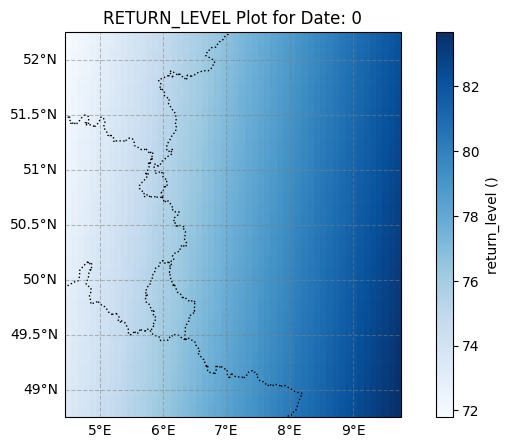

In [220]:
plot_datacube(ds.sel(stat = "estimate",return_period=100),variable="return_level", interpolation=None)

In [216]:
ds.sel(stat = "estimate",return_period=100)

<xarray.Dataset> Size: 9kB
Dimensions:        (time: 1, lat: 36, lon: 54)
Coordinates:
    return_period  int32 4B 100
  * time           (time) int32 4B 0
  * lat            (lat) float64 288B 48.75 48.85 48.95 ... 52.05 52.15 52.25
  * lon            (lon) float64 432B 4.45 4.55 4.65 4.75 ... 9.55 9.65 9.75
    stat           <U8 32B 'estimate'
Data variables:
    return_level   (time, lat, lon) float32 8kB 0.465 0.4622 ... 0.4655 0.4692

In [217]:
ds

<xarray.Dataset> Size: 94kB
Dimensions:        (return_period: 4, time: 1, lat: 36, lon: 54, stat: 3)
Coordinates:
  * return_period  (return_period) int32 16B 5 25 100 1000
  * time           (time) int32 4B 0
  * lat            (lat) float64 288B 48.75 48.85 48.95 ... 52.05 52.15 52.25
  * lon            (lon) float64 432B 4.45 4.55 4.65 4.75 ... 9.55 9.65 9.75
  * stat           (stat) <U8 96B 'estimate' 'lower' 'upper'
Data variables:
    return_level   (return_period, time, lat, lon, stat) float32 93kB 0.1551 ...

<Figure size 1200x900 with 0 Axes>

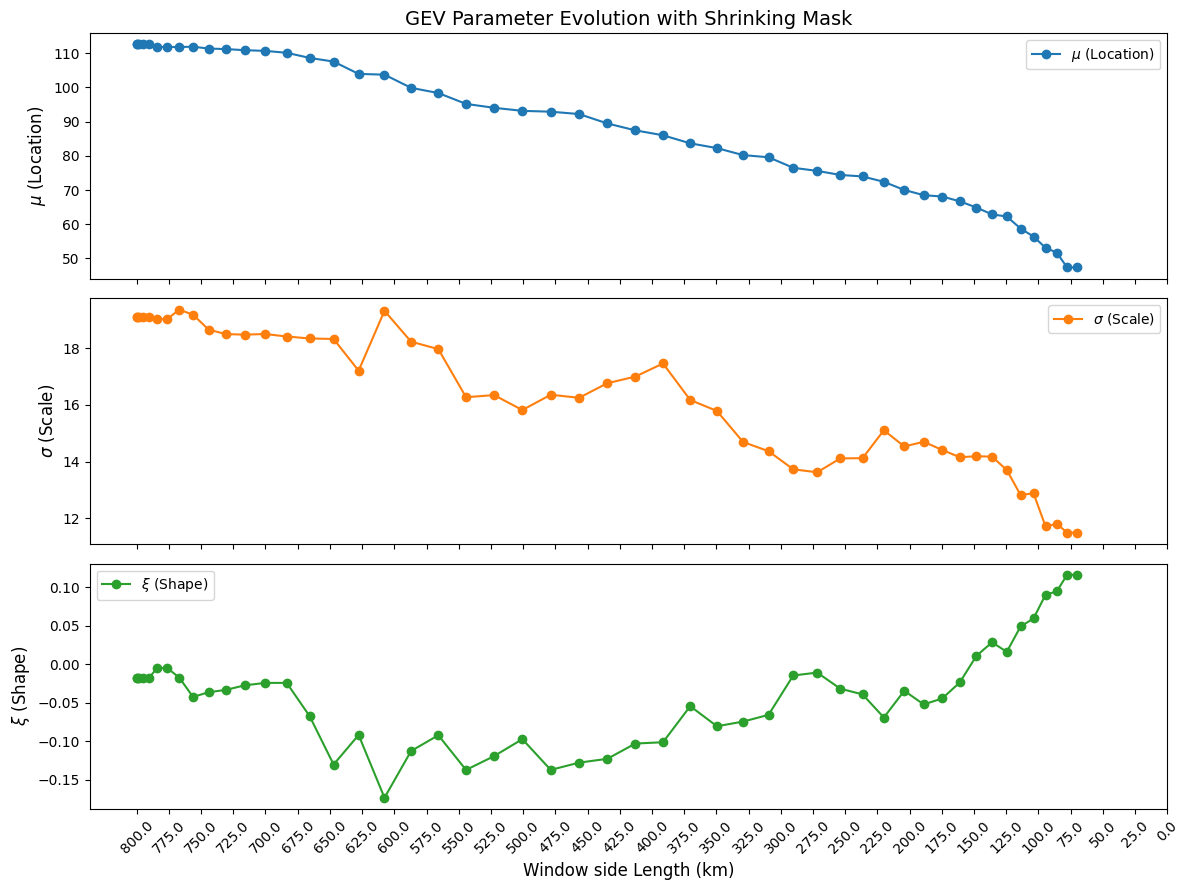

In [88]:
# Define the placeholder magicFunction
def estimate_gev_parameters(ds, exog):
    """
    Estimate GEV parameters for the given dataset.

    Parameters:
    ds (xarray.Dataset): The dataset (masked region) to estimate GEV parameters from.
    exog (dict): The exogenous variable for the GEV model (e.g., temp anomaly).

    Returns:
    float: The estimated location parameter (mu) from the GEV model.
    """
    # Calculate block maxima
    block_max_data = block_maximum(ds)
    # Fit the GEV model
    model = GEVLikelihood(endog=block_max_data["prmax"], exog=exog, full_output=True)
    fit_result = model.fit()

    # Return the location parameter (mu)
    return (fit_result.fitted_params[0],fit_result.fitted_params[1],fit_result.fitted_params[2])

def iterative_gev_estimation(ds, center, initial_side_length, exog, min_side_length=50, num_steps=50):
    """
    Iteratively masks a smaller region from the dataset, applies GEV estimation, and plots the results.

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing latitude and longitude data.
    center (tuple): A tuple of coordinates (longitude, latitude) representing the center of the mask.
    initial_side_length (float): The side length of the initial square mask in degrees.
    exog (dict): The exogenous variable for the GEV model (e.g., temp anomaly).
    min_side_length (float): The minimum side length for the iterative process (default is 1 degree).
    num_steps (int): The number of steps in the iteration (default is 50).

    Returns:
    None
    """
    # Initialize side length and results
    half_side = initial_side_length/2
    mu_values, sigma_values, xi_values = [], [], []
    sizes = []
    masked_ds = ds
    for step in range(num_steps):
        # Save the current side length
        sizes.append(half_side*2)

        masked_ds = mask_square_true(masked_ds,center,half_side)
        # Perform GEV estimation on the masked dataset
        try:
            mu, sigma, xi = estimate_gev_parameters(masked_ds, exog)
        except Exception as e:
            print(f"Failed to fit GEV model at step {step}: {e}")
            mu, sigma, xi = np.nan, np.nan, np.nan  # Assign NaN if fitting fails

        mu_values.append(mu)
        sigma_values.append(sigma)
        xi_values.append(xi)

        # Stop if the side length reaches or drops below the minimum
        if half_side <= min_side_length/2:
            break

        # Calculate an adaptive shrink factor (starts near 1, decreases gradually)
        shrink_factor = 1 - (1 - 0.9) * (step / num_steps)
        half_side *= shrink_factor

    # Plot the results for all three parameters
    plt.figure(figsize=(12, 9))

    # Define a consistent color palette
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

    # Create the figure with a common x-axis
    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    # Plot mu (Location parameter)
    axs[0].plot(sizes, mu_values, marker='o', linestyle='-', color=colors[0], label=r'$\mu$ (Location)')
    axs[0].invert_xaxis()  # Reverse x-axis so larger sizes are on the left
    axs[0].set_ylabel(r'$\mu$ (Location)', fontsize=12)
    axs[0].set_title('GEV Parameter Evolution with Shrinking Window', fontsize=14)
    axs[0].legend(fontsize=10)
    axs[0].tick_params(axis='both', which='both', labelsize=10)

    # Plot sigma (Scale parameter)
    axs[1].plot(sizes, sigma_values, marker='o', linestyle='-', color=colors[1], label=r'$\sigma$ (Scale)')
    axs[1].invert_xaxis()
    axs[1].set_ylabel(r'$\sigma$ (Scale)', fontsize=12)
    axs[1].legend(fontsize=10)
    axs[1].tick_params(axis='both', which='both', labelsize=10)

    # Plot xi (Shape parameter)
    axs[2].plot(sizes, xi_values, marker='o', linestyle='-', color=colors[2], label=r'$\xi$ (Shape)')
    axs[2].invert_xaxis()
    axs[2].set_xlabel('Window side Length (km)', fontsize=12)
    axs[2].set_ylabel(r'$\xi$ (Shape)', fontsize=12)
    axs[2].legend(fontsize=10)
    axs[2].tick_params(axis='both', which='both', labelsize=10)

    # Increase precision on the x-axis (more tick marks)
    axs[2].set_xticks(np.arange(0, 825, 25))  # Customize the step size of the x-axis ticks for more precision
    axs[2].set_xticklabels([f'{i:.1f}' for i in np.arange(0, 825, 25)], rotation=45)  # Format ticks with decimal precision

    # Adjust layout for better spacing and visibility
    plt.tight_layout()

    # Show the plot
    plt.show()

iterative_gev_estimation(spherical_ds,center,800,{})

### 📂 Loading Section: DataCube Loading Functions

This section is specialized in loading space-time datacubes from various file formats, such as NetCDF, while applying the masks built in **Section 1**. These masks help reduce the dataset size by cropping the datacube in time, space, or both, making it more efficient to work with and easier to manipulate.


In [10]:
def convert_360_to_180(values):
        return xr.where(values < 180, values, values - 360)

def load_netcdf(filepath, coords=('rr','latitude','longitude'), use_cftime=True):
    """
    Load a NETCDF file and return it as an xarray dataset.

    Parameters:
    filepath (str): Path to the NETCDF file to be loaded.
    use_cftime (bool): Whether to use cftime for handling dates out of numpy range. Default is True.
    Returns:
    xarray.Dataset: The loaded dataset.
    """
    try:
        dataset = xr.open_dataset(filepath, engine='netcdf4', use_cftime=use_cftime)
        coord_names = list(dataset.coords.keys())
        datavars_names = list(dataset.data_vars.keys())
        if 'pr' not in datavars_names:
            dataset = dataset.rename({coords[0]: 'pr'})
            dataset['pr'].attrs['units'] = 'mm/day'
        else:
            dataset['pr'] = dataset['pr'] * 86400
            dataset['pr'].attrs['units'] = 'mm/day'
        if 'lat' not in coord_names:
            dataset = dataset.rename({coords[1]: 'lat'})
        if 'lon' not in coord_names:
            dataset = dataset.rename({coords[2]: 'lon'})
        return dataset
    except FileNotFoundError:
        print(f"Error: The file at '{filepath}' was not found.")
    except ImportError:
        print("Error: Required dependencies for reading NETCDF files are not installed. Please refer to https://docs.xarray.dev/en/stable/getting-started-guide/installing.html")
    except Exception as e:
        print(f"An error: {e}")

# Example usage:
# ds = load_netcdf('path/to/netcdf_file.nc')
# print(ds)

def assemble_datacube(folderpath, crop=(True,(7.0, 50.5),2,'summer'), max_files=100):
    """
    Assemble a datacube along the time dimension from multiple NETCDF files in a folder until a certain maximum number of files is reached.
    
    Parameters:
    folderpath (str): Path to the folder containing NETCDF files.
    max_files (int, optional): The maximum number of NETCDF files to read for the assembled datacube. Default is 100.

    Returns:
    xarray.Dataset: The assembled datacube.
    """
    
    datacube = None  # Initialize an empty datacube to concatenate into
    file_count = 0

    try:
        for filename in os.listdir(folderpath):
            if filename.endswith(".nc"):
                filepath = os.path.join(folderpath, filename)
                if crop[0]:
                    ds = mask_time(mask_square(load_netcdf(filepath), crop[1], crop[2]),'summer')
                else:
                    ds = load_netcdf(filepath)
                if datacube is None:
                    datacube = ds  # Initialize the datacube
                else:
                    ds = ds.reindex(
                    lat=datacube['lat'],
                    lon=datacube['lon'],
                    method="nearest", tolerance=1e-5
                    )
                    datacube = xr.concat([datacube, ds], dim='time')  # Concatenate along time dimension
                file_count += 1
                if file_count >= max_files:
                    break
            print("NEXT")
        return datacube
        #if datacube is not None:
            #datacube['lon'] = convert_360_to_180(datacube['lon'])  # Convert longitudes if needed
            #datacube = datacube.sortby(['lat', 'lon'])  # Sort by lat and lon
            #return datacube
        #else:
            #print("No valid NETCDF files found in the folder.")
    except Exception as e:
        print(f"An error occurred while assembling the datacube: {e}")

# Example usage:
# datacube = assemble_datacube('path/to/folder')
# print(datacube)

### 🎨 Plotting Section: Static and Dynamic Visualization Functions

This section focuses on plotting data either statically or dynamically using animations in **Matplotlib**. The functions in this section use the loaded data from **Section 2** and allow users to visualize the masks applied in **Section 1**, both in time and space. These visualizations are powerful tools to ensure the data is well-conditioned in both dimensions and provide insightful visual analysis.

#### 📊 Static Plots:
- Visualize data at specific time steps or spatial regions.
- Check how masks affect the data over time or space.

#### 🎞️ Dynamic Plots (Animations):
- Create time-lapse visualizations to observe temporal evolution.
- Useful for understanding changes in datasets across multiple time frames.

In [17]:
def plot_datacube(ds, variable='pr', time_step=0, ax=None, cbar_ax=None, fig=None, figsize=(5, 5), norm=None, interpolation=None, cmap='Blues', title=None, label=None):
    """
    Plot a single time step of the datacube for a specified variable, or just the data if no time dimension exists.

    Parameters:
    ds (xarray.Dataset): The dataset containing the data to be plotted.
    variable (str, optional): The name of the variable to plot. Default is 'pr'.
    time_step (int, optional): The time step to plot. Default is 0.
    ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis to plot on. Default is None.
    cbar_ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis for the colorbar. Default is None.
    fig (matplotlib.figure.Figure, optional): Figure object for adding the colorbar. Default is None.
    figsize (tuple, optional): Figure size. Default is (10, 5).
    norm (optional): Normalization for color mapping. Default is None.
    interpolation (str, optional): Interpolation method for imshow. Default is None.
    cmap (str or Colormap, optional): Colormap for the plot. Default is 'Blues'.
    """
    if ax is None or cbar_ax is None or fig is None:
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 0.05])
        ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
        cbar_ax = fig.add_subplot(gs[0,1])

    # Check if the variable exists in the dataset
    if variable not in ds:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")

    if 'time' in ds.dims:
        data = ds[variable].isel(time=time_step)
        if title is None:
            title = f"{variable.upper()} Plot for Date: {str(ds.time.values[time_step])}"
    else:
        data = ds[variable]
        if title is None:
            title = f"{variable.upper()} Plot"

    # Plot the data
    img = ax.imshow(data, origin='lower', transform=ccrs.PlateCarree(), cmap=cmap,
                    extent=[ds['lon'].min(), ds['lon'].max(), ds['lat'].min(), ds['lat'].max()],
                    interpolation=interpolation, norm=norm)  # Allow selection of interpolation and colormap

    # Ensure correct aspect ratio
    ax.set_aspect('auto')

    ax.coastlines()
    ax.add_feature(ftr.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    ax.set_title(title)

    # Update colorbar with the variable's name and units (default to 'unknown units' if not provided)
    units = ds[variable].attrs.get('units', '')
    units = ds[variable].attrs.get('units', '')
    if label is None:
        fig.colorbar(img, ax=ax, cax=cbar_ax, shrink=0.5, aspect=1, label=f"{variable} ({units})")  
    else:
        fig.colorbar(img, ax=ax, cax=cbar_ax, shrink=0.5, aspect=1, label=label) 

    if ax is None or cbar_ax is None or fig is None:
        plt.show()

#global_min, global_max = CMISP_summer['pr'].min(), CMISP_summer['pr'].quantile(0.975)
#norm = colors.Normalize(vmin=global_min, vmax=global_max)
#plot_datacube(CMISP_summer, figsize = (8,6),norm=norm)
def animate_datacube(ds, variable='pr', time_range=10, norm=None, interpolation=None, cmap='Blues'):
    """
    Create an animation of the datacube over the time dimension for a specified variable.

    Parameters:
    ds (xarray.Dataset): The dataset containing the data to be animated.
    variable (str, optional): The name of the variable to animate. Default is 'pr'.
    time_range (int, optional): The number of time steps to animate. Default is 10.
    norm (optional): Normalization for color mapping. Default is None.
    interpolation (str, optional): Interpolation method for imshow. Default is None.
    cmap (str or Colormap, optional): Colormap for the animation. Default is 'Blues'.
    """
    # Set up the figure and axis
    gs = GridSpec(1, 2, width_ratios=[0.9, 0.05])
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    cbar_ax = fig.add_subplot(gs[1])

    # Update function for animation
    def update(frame):
        ax.clear()
        plot_datacube(ds, variable=variable, time_step=frame, ax=ax, cbar_ax=cbar_ax, fig=fig, norm=norm, interpolation=interpolation, cmap=cmap)

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=min(time_range, ds.dims.get('time', 1)), interval=500)
    plt.rcParams['animation.embed_limit'] = 50  # Set embed limit to 50 MB
    return HTML(ani.to_jshtml())


### Processing functions

In [50]:
def save_tempanomaly(ds, filepath, blockpath, start_year='1950-01-01', end_year='2024-12-31'):
    """
    Calculate the annual mean temperature anomaly from the given dataset and save it as a CSV file.

    Parameters:
    ds (xarray.Dataset): The dataset containing the temperature anomaly data ('tempanomaly').
    filepath (str): The path to save the resulting CSV file.
    start_year (str, optional): The start year for the data to be considered. Default is '1950-01-01'.
    end_year (str, optional): The end year for the data to be considered. Default is '2024-12-31'.

    Returns:
    pandas.DataFrame: A DataFrame with years and mean temperature anomalies.

    Example usage:
    save_tempanomaly(GISTEMP, 'output/annual_mean_tempanomaly.csv')
    """
    # Filter the dataset to only include years between start_year and end_year
    ds_filtered = ds.sel(time=slice(start_year, end_year))
    
    # Resample the data to an annual frequency and calculate the mean for each year across 'lat' and 'lon'
    annual_mean_tempanomaly = ds_filtered['tempanomaly'].resample(time='1Y').mean(dim=['time', 'lat', 'lon']).to_dataframe().reset_index()
    
    # Extract the year from the time column and create a 'year' column
    annual_mean_tempanomaly['year'] = annual_mean_tempanomaly['time'].apply(lambda x: x.year)
    annual_mean_tempanomaly = annual_mean_tempanomaly[['year', 'tempanomaly']]
    annual_mean_tempanomaly.rename(columns={'tempanomaly': 'tempanomalyMean'}, inplace=True)
    
    # Check if the Blockmax CSV file exists
    blockmax_filepath = blockpath
    if not os.path.exists(blockmax_filepath):
        raise FileNotFoundError(f"The file '{blockmax_filepath}' was not found.")
    
    # Load the Blockmax DataFrame and merge with the annual mean temperature anomaly DataFrame
    blockmax_df = pd.read_csv(blockmax_filepath)
    merged_df = pd.merge(blockmax_df, annual_mean_tempanomaly, on='year')
    
    # Save the resulting DataFrame as a CSV file
    merged_df.to_csv(filepath, index=False)
    
    return merged_df

### 📊 EVT Analysis Section: Block Maxima and Peak Over Threshold

This section focuses on transforming the data to correspond with the two main philosophies of Extreme Value Theory (EVT): **Block Maxima** and **Peak Over Threshold (POT)**. These transformations help prepare the data for EVT analysis, which is crucial for studying extreme events.

#### 🌐 EVT Techniques:
1. **Block Maxima**: Divides the dataset into blocks (e.g., yearly or monthly) and retains only the maximum value from each block, allowing for the analysis of extreme values within those blocks.
2. **Peak Over Threshold (POT)**: Focuses on values that exceed a predefined threshold, retaining all data points that represent extremes beyond that threshold.

In [22]:
def block_maximum(ds):
    """
    Calculate the maximum precipitation value per year over all spatial dimensions and time jointly, and return a pandas DataFrame.

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing the precipitation data ('pr'). The dataset should be masked in space and time.

    Returns:
    pandas.DataFrame: A DataFrame with years as the index and maximum precipitation values as the column.

    Example usage:
    df_max_precip = block_maximum(ds_summer)
    """
    # Resample the dataset to annual frequency and take the maximum value for each year over all dimensions (time, lat, lon)
    annual_max = ds['pr'].resample(time='1YE').max(dim=['time', 'lat', 'lon'])
    # Create a DataFrame from the resampled data
    df_max_precip = annual_max.to_dataframe().reset_index()
    # Extract only the year from the time column
    df_max_precip['year'] = df_max_precip['time'].apply(lambda x: x.year)
    df_max_precip = df_max_precip[['year', 'pr']]
    df_max_precip.rename(columns={'pr': 'prmax'}, inplace=True)
    return df_max_precip

### 💾 Export Section: Export Processed Data to CSV

This section handles the export of processed data, such as the results from the EVT analysis, to CSV format for further use or sharing. This ensures that the processed data is stored in a widely compatible format, allowing for easy access and use outside the current environment.

In [52]:
def export_csv(df, filepath, overwrite=True):
    """
    Export a pandas DataFrame to a CSV file. Allows overwriting if the file already exists.

    Parameters:
    df (pandas.DataFrame): The DataFrame to be exported.
    filepath (str): The path where the CSV file will be saved.
    overwrite (bool, optional): Whether to overwrite the file if it already exists. Default is True.

    Example usage:
    export_csv(df_max_precip, 'output/max_precipitation.csv')
    """
    import os
    if os.path.exists(filepath) and not overwrite:
        raise FileExistsError(f"The file '{filepath}' already exists and overwrite is set to False.")
    df.to_csv(filepath, index=False)


filepath = r"c:\Users\bobel\Downloads\pr_day_EC-Earth3_piControl_r1i1p1f1_gr_22590101-22591231.nc"
#export_csv(CMISP_blockmax,filepath)

### 🛠️ Practical Section: Applying the Function Corpus to Process Data
In this section, we demonstrate how to use the function corpus to process various datasets from start to finish. This includes loading the data, applying space-time masks, performing EVT analysis, visualizing the data, and exporting the processed results.

#### 🔄 Step-by-Step Workflow (example):

1. **Load the Data**: We first load the dataset (e.g., a space-time datacube) using the functions from the **Loading Section**.
2. **Apply Masks**: Next, we crop the dataset spatially, temporally, or both using the masking functions from **Section 1**.
3. **EVT Analysis**: After masking, we transform the data using the **Block Maxima** or **Peak Over Threshold** methods from the **EVT Section**.
4. **Visualize the Data**: Before finalizing the analysis, we create both static and dynamic visualizations using the **Plotting Section** functions to ensure the data is properly conditioned.
5. **Export the Data**: Finally, we export the processed data to CSV format for external use or storage using the **Export Section** function.

### CMISP Data

In [ ]:
CMISP_summer = assemble_datacube(folderpath=r"c:\ThesisData\CMISP",max_files=100)
global_min = EOBS_summer['pr'].min()
global_max = EOBS_summer['pr'].quantile(0.975)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
animate_datacube(EOBS_summer.sel(time=slice(EOBS_summer.time[-60], EOBS_summer.time[-1])), time_range=3,norm=norm)
CMISP_blockmax = block_maximum(CMISP_summer)
CMISP_blockmax


### EOBS Data

In [11]:
center_coordinates = (7.0, 50.5)  # Center around Ahr-Eifel basin (longitude, latitude)
side_length = 1.5  # Side length of the square in degrees
EOBS_summer = mask_time(
    mask_square(
        load_netcdf(filepath=r"c:\ThesisData\EOBS\RainFallMeanEnsemble\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
        center_coordinates,
        side_length
    ),
    season='summer'
)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[1], line 4
      1 center_coordinates = (7.0, 50.5)  # Center around Ahr-Eifel basin (longitude, latitude)
      2 side_length = 1.5  # Side length of the square in degrees
      3 EOBS_summer = mask_time(
----> 4     mask_square(
      5         load_netcdf(filepath=r"c:\ThesisData\EOBS\RainFallMeanEnsemble\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
      6         center_coordinates,
      7         side_length
      8     ),
      9     season='summer'
     10 )

NameError: name 'mask_square' is not defined


Error: NameError

In [118]:
ds_new = mask_time(spherical_ds.dropna(dim="lon"),season="summer")
#blockmax = export_csv(block_maximum(EOBS_summer),r"C:\ThesisData\EOBS\Blockmax\blockmax.csv")

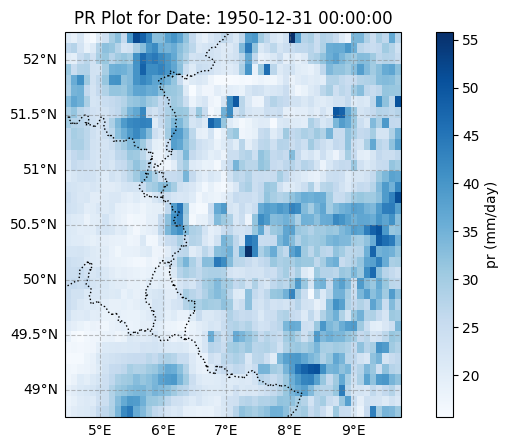

In [135]:
annual_max = ds_new['pr'].resample(time='1YE').max(dim=['time']).to_dataset()
plot_datacube(annual_max)

In [136]:
annual_max

<xarray.Dataset> Size: 585kB
Dimensions:  (lat: 36, lon: 54, time: 75)
Coordinates:
  * lat      (lat) float64 288B 48.75 48.85 48.95 49.05 ... 52.05 52.15 52.25
  * lon      (lon) float64 432B 4.45 4.55 4.65 4.75 4.85 ... 9.45 9.55 9.65 9.75
  * time     (time) object 600B 1950-12-31 00:00:00 ... 2024-12-31 00:00:00
Data variables:
    pr       (time, lat, lon) float32 583kB 18.6 20.0 20.7 ... 22.7 17.4 16.3

In [159]:
t = len(annual_max['time'])

new_var_data = annual_mean_tempanomaly['tempanomaly'].values  # Shape: (t,)

new_var_da = xr.DataArray(
    new_var_data,
    dims=('time',),
    coords={
        'time': annual_max['time']
    },
    name='tempanomaly'
)

annual_max['tempanomaly'] = new_var_da

In [160]:
annual_max

<xarray.Dataset> Size: 585kB
Dimensions:      (lat: 36, lon: 54, time: 75)
Coordinates:
  * lat          (lat) float64 288B 48.75 48.85 48.95 ... 52.05 52.15 52.25
  * lon          (lon) float64 432B 4.45 4.55 4.65 4.75 ... 9.45 9.55 9.65 9.75
  * time         (time) object 600B 1950-12-31 00:00:00 ... 2024-12-31 00:00:00
Data variables:
    pr           (time, lat, lon) float32 583kB 18.6 20.0 20.7 ... 17.4 16.3
    tempanomaly  (time) float32 300B -0.1207 -0.06782 0.08372 ... 1.291 1.419

In [161]:
endog, exog = xarray_to_endog_exog(annual_max,'pr',include_coords=True)

In [162]:
exog.shape

(75, 3, 1944)

In [165]:
 exogtest = {
        "location": exog,  
        "scale": None,    
        "shape": None     
    }

In [166]:
np.savez(f'my_data.npz', endog=endog, exog=exog)

In [150]:
gevModel = GEVSample(endog=endog,exog=exogtest, T=50)
print(gevModel.fit(fit_method="mle").return_level(t=[0,35],s=[0,10,30]))

INFO:root:ℹ️ The location parameter (μ) will be redefined in terms of return levels (z_p), as you have specified a return period (T).
---------------------------------------------------------------------------
LinAlgError                               Traceback (most recent call last)
Cell In[1], line 2
      1 gevModel = GEVSample(endog=endog,exog=exogtest, T=50)
----> 2 print(gevModel.fit(fit_method="mle").return_level(t=[0,35],s=[0,10,30]))

File c:\github\EVT_Univariate\Exploration\..\EVT_Classes\GEV.py:512, in GEVSample.fit(self, start_params, optim_method, fit_method)
    510 match fit_method.lower():
    511     case "mle":
--> 512         return self._fit_mle(start_params, optim_method, RL_args)
    513     case "profile":
    514         return self._fit_profile(start_params, optim_method, RL_args)

File c:\github\EVT_Univariate\Exploration\..\EVT_Classes\GEV.py:531, in GEVSample._fit_mle(self, start_params, optim_method, RL_args)
    529 self.result = minimize(self.nloglike, 

Error: LinAlgError

In [127]:
endog

array([[18.6     , 20.      , 20.7     , ..., 26.4     , 36.5     ,
        27.4     ],
       [22.9     , 24.2     , 25.2     , ..., 26.6     , 34.600002,
        22.800001],
       [16.4     , 16.800001, 17.4     , ..., 19.5     , 17.      ,
        17.      ],
       ...,
       [42.5     , 45.600002, 45.600002, ..., 18.6     , 18.      ,
        15.2     ],
       [37.2     , 33.100002, 29.9     , ..., 44.100002, 43.3     ,
        57.3     ],
       [19.2     , 19.7     , 21.5     , ..., 22.7     , 17.4     ,
        16.300001]], dtype=float32)

In [28]:
EOBS_summer_FULL = mask_time(load_netcdf(filepath=r"c:\ThesisData\EOBS\RainFallMeanEnsemble\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
season='summer')
EOBS_summer_FULL

<xarray.Dataset> Size: 18GB
Dimensions:  (lat: 465, lon: 705, time: 13633)
Coordinates:
  * lat      (lat) float64 4kB 25.05 25.15 25.25 25.35 ... 71.25 71.35 71.45
  * lon      (lon) float64 6kB -24.95 -24.85 -24.75 -24.65 ... 45.25 45.35 45.45
  * time     (time) object 109kB 1950-04-01 00:00:00 ... 2024-06-30 00:00:00
Data variables:
    pr       (time, lat, lon) float32 18GB ...
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 12:04:01 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....

In [ ]:
ds = xr.open_dataset(r"c:\ThesisData\TempAnomaly\gistemp1200_GHCNv4_ERSSTv5.nc")
ds_filtered = ds.sel(time=slice('1950-01-01', '2024-12-31'))
# Resample the data to an annual frequency and calculate the mean for each year across 'lat' and 'lon'
annual_mean_tempanomaly = ds_filtered['tempanomaly'].resample(time='1YE').mean(dim=['time', 'lat', 'lon']).to_dataframe().reset_index()
#save_tempanomaly(ds,filepath=r"C:\ThesisData\EOBS\Blockmax\blockmax_temp.csv",blockpath=r"c:\ThesisData\EOBS\Blockmax\blockmax.csv")

In [64]:
ds_filtered

<xarray.Dataset> Size: 58MB
Dimensions:      (lat: 90, lon: 180, time: 898, nv: 2)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2024-10-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 14kB ...
    tempanomaly  (time, lat, lon) float32 58MB ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2024-11-06 08:52:23 by SBBX_to_nc 2.0 - ILAND=1200,...

In [81]:
annual_mean_tempanomaly

,time,tempanomaly
0,1950-12-31,-0.120654
1,1951-12-31,-0.067821
2,1952-12-31,0.083716
3,1953-12-31,0.231786
4,1954-12-31,0.002661
...,...,...
70,2020-12-31,1.226882
71,2021-12-31,0.962016
72,2022-12-31,1.102626
73,2023-12-31,1.291236


### GISTEMP Data

In [ ]:
GISTEMP = xr.open_dataset(r"c:\Users\bobel\Downloads\gistemp1200_GHCNv4_ERSSTv5.nc", engine='netcdf4')
GISTEMP
save_tempanomaly(GISTEMP,r"c:\Users\bobel\Downloads\UCL_blockmax.csv",r"c:\Users\bobel\Downloads\UCL_blockmax.csv")


### Uccles Data

In [ ]:
df = pd.read_csv(r"c:\Users\bobel\OneDrive - Université de Namur\Data\UCCLES\Precip_Uccle_1892.csv")
df['DAY'] = pd.to_datetime(df['DAY'])
df['year'] = df['DAY'].dt.year
# Group by year and calculate the max precipitation for each year
max_precip_per_year = df.groupby('year')['PRECIP_QUANTITY'].max().reset_index()
max_precip_per_year
export_csv(filepath=r"c:\Users\bobel\OneDrive - Université de Namur\Data\Blockmax\UCL_blockmax.csv",df=max_precip_per_year)

Model Comparison

1. **Stationary**: No covariate dependence.
   - $ \mu $, $ \sigma $, $ \xi $ are constant.

2. **Loc-linear**: Linear dependence on location.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma $, $ \xi $

3. **Loc+Shape-linear**: Linear dependence on location and shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma = \alpha_0 + \alpha_0 x_1 $, $ \xi $

4. **Loc+Scale+Shape-linear**: Linear dependence on location, scale, and shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma = \alpha_0 + \alpha_1 x_1 $, $ \xi = \gamma_0 + \gamma_1 x_1 $

5. **Stationary (scale exp link)**: Stationary model with an exponential link on shape.
   - $ \mu $, $ e^{\alpha_0} $, $ \xi $

6. **Loc-linear (scale exp link)**: Linear dependence on location with an exponential link on shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $\sigma = e^{\alpha_0}$, $ \xi $

7. **Loc+Shape-linear (scale exp link)**: Linear dependence on location and shape, with an exponential link on shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma = e^{\alpha_0 + \alpha_1 x_1} $, $ \xi$

8. **Loc+Scale+Shape-linear (scale exp link)**: Linear dependence on location, scale, and shape, with an exponential link on shape.
   - $ \mu = \beta_0 + \beta_1 x_1 $, $ \sigma = e^{\alpha_0 + \alpha_1 x_1} $, $ \xi = \gamma_0 + \gamma_1 x_1 $

In [25]:
from GEV import * 
EOBS = pd.read_csv(r"c:\ThesisData\EOBS\Blockmax\blockmax_temp.csv")
exog1 = {}
exog2 = {'location':EOBS['tempanomalyMean'].values}
exog3 = {'location':EOBS['tempanomalyMean'].values,
'scale' : EOBS['tempanomalyMean'].values}
exog4 = {'location':EOBS['tempanomalyMean'].values,
'shape' : EOBS['tempanomalyMean'].values, 'scale': EOBS['tempanomalyMean'].values}

fit1 = GEVSample(endog=EOBS["prmax"].values,exog=exog1).fit()
fit2 = GEVSample(endog=EOBS["prmax"].values,exog=exog2).fit()
fit3 = GEVSample(endog=EOBS["prmax"].values,exog=exog3).fit()
fit4 = GEVSample(endog=EOBS["prmax"].values,exog=exog4).fit()
#fit5 = GEV(endog=EOBS["prmax"].values,exog=exog1,scale_link=GEV.exp_link,full_output=True).fit()
#fit6 = GEV(endog=EOBS["prmax"].values,exog=exog2,scale_link=GEV.exp_link, full_output=True).fit()
#fit7 = GEV(endog=EOBS["prmax"].values,exog=exog3,scale_link=GEV.exp_link, full_output=True).fit()
#fit8 = GEV(endog=EOBS["prmax"].values,exog=exog4,scale_link=GEV.exp_link, full_output=True).fit()
#fit9 = GEVTradowsky(endog=EOBS["prmax"].values,exog=exog5, full_output=True).fit()

import pandas as pd
# Assuming each fit object has .AIC() and .BIC() methods
# Replace these calls with the actual AIC and BIC values from your model fits
data = {
    "Model Name": [
        "Stationary",
        "Loc-linear",
        "Loc+scale-linear",
        "Loc+Scale+Shape-linear",
    ],
    "AIC": [fit1.AIC(), fit2.AIC(), fit3.AIC(), fit4.AIC()],
    "BIC": [fit1.BIC(), fit2.BIC(), fit3.BIC(), fit4.BIC()]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Use pandas Styler to format the table nicely
styled_df = df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]}
]).format(precision=2).set_properties(**{
    'text-align': 'center',
    'font-family': 'Arial, sans-serif',
    'border-collapse': 'collapse'
}).set_caption("Model Comparison: AIC and BIC Scores")

styled_df

75
75
75
75


,Model Name,AIC,BIC
0,Stationary,641.37,648.32
1,Loc-linear,639.05,648.32
2,Loc+scale-linear,640.06,651.65
3,Loc+Scale+Shape-linear,642.05,655.96


In [26]:
print("LINEAR LOCATION MODEL")
print(fit2)

LINEAR LOCATION MODEL
75

          EVT Results Summary       
Data dimensions : (75, 1)
AIC: 639.05  
BIC: 648.32  

+------------+--------------+--------------+--------------+---------------------------+----------+
| Parameter  | Estimate     | Z-score      | P>|Z-score|  | 95% CI                    | Signif   |
+------------+--------------+--------------+--------------+---------------------------+----------+
| μ_0        | 69.1836      | 31.52        | 0.0000       | (64.8823, 73.4850)        | ***      |
| μ_1        | 7.8452       | 2.13         | 0.0334       | (0.6165, 15.0740)         | *        |
| σ_0        | 13.7198      | 10.22        | 0.0000       | (11.0896, 16.3499)        | ***      |
| ξ_0        | 0.0149       | 0.16         | 0.8746       | (-0.1706, 0.2004)         |          |
+------------+--------------+--------------+--------------+---------------------------+----------+
Significance : *** p<0.001, ** p<0.01, * p<0.05



Parameters map (location, scale, shape, alpha {Tradowsky})

In [12]:
center_coordinates = (7.0,50)  # Center around Ahr-Eifel basin (longitude, latitude)
side_length = 10
EOBS_summer = mask_rectangle(ds = mask_time(load_netcdf(filepath=r"c:\ThesisData\EOBS\RainFallMeanEnsemble\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
'summer'), center = center_coordinates,side_length=side_length)
EOBS_summer

<xarray.Dataset> Size: 545MB
Dimensions:  (time: 13633, lat: 100, lon: 100)
Coordinates:
  * lat      (lat) float64 800B 45.05 45.15 45.25 45.35 ... 54.75 54.85 54.95
  * lon      (lon) float64 800B 2.05 2.15 2.25 2.35 ... 11.65 11.75 11.85 11.95
  * time     (time) object 109kB 1950-04-01 00:00:00 ... 2024-06-30 00:00:00
Data variables:
    pr       (time, lat, lon) float32 545MB 2.0 1.7 2.2 0.0 ... nan nan nan nan
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 12:04:01 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....

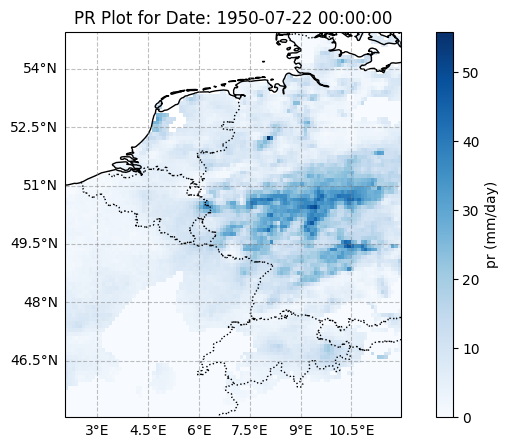

In [108]:
plot_datacube(EOBS_summer,time_step=112)

In [13]:
def block_maximum_grid(ds): 
    """
    Calculate the maximum precipitation value per year for each pixel individually and return an xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The xarray dataset containing the precipitation data ('pr').

    Returns:
    xarray.Dataset: A Dataset with yearly maximum precipitation values for each pixel.
    """
    # Resample the dataset to annual frequency and take the maximum value for each year over the time dimension only
    annual_max = ds['pr'].resample(time='1YE').max(dim='time')
    out = annual_max.to_dataset(name='pr')

    # The result is an xarray Dataset with the maximum precipitation per year for each lat-lon pixel
    return out

EOBS_blockmax_grid = block_maximum_grid(EOBS_summer)
global_min = EOBS_blockmax_grid['pr'].min()
global_max = EOBS_blockmax_grid['pr'].quantile(0.975)
norm = colors.Normalize(vmin=global_min, vmax=global_max)

EOBS_blockmax_grid

<xarray.Dataset> Size: 3MB
Dimensions:  (lat: 100, lon: 100, time: 75)
Coordinates:
  * lat      (lat) float64 800B 45.05 45.15 45.25 45.35 ... 54.75 54.85 54.95
  * lon      (lon) float64 800B 2.05 2.15 2.25 2.35 ... 11.65 11.75 11.85 11.95
  * time     (time) object 600B 1950-12-31 00:00:00 ... 2024-12-31 00:00:00
Data variables:
    pr       (time, lat, lon) float32 3MB 30.4 25.1 20.7 20.3 ... nan nan nan

In [145]:
def fit_gev_model(ds, exog={'location':EOBS["tempanomalyMean"]}):
    """
    Fit a GEV model to each spatial pixel's time series of prmax values,
    compute the signal-to-noise ratio (SNR) for each parameter,
    and store the results in an xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing the annual maximum precipitation ('prmax') for each pixel.
    exog (array-like): The exogenous variables used in the GEV model.

    Returns:
    xarray.Dataset: A Dataset containing the fitted parameters and SNR for each spatial pixel.
    """
    # Initialize arrays to store the model parameters and SNR for each pixel
    #location_param = np.full((ds.sizes['lat'], ds.sizes['lon']), np.nan)
    #b1_param = np.full((ds.sizes['lat'], ds.sizes['lon']), np.nan)
    #scale_param = np.full((ds.sizes['lat'], ds.sizes['lon']), np.nan)
    #shape_param = np.full((ds.sizes['lat'], ds.sizes['lon']), np.nan)
    rl_param = np.full((ds.sizes['lat'], ds.sizes['lon']), np.nan)
    
    # Loop over each spatial pixel
    for i, lat in enumerate(ds['lat'].values):
        for j, lon in enumerate(ds['lon'].values):
            # Extract the time series for the current pixel
            prmax_series = ds['pr'].sel(lat=lat, lon=lon).values

            # Check if the time series is valid (e.g., not all NaNs)
            if np.any(~np.isnan(prmax_series)):
                # Fit the GEV model
                model = GEVSample(endog=prmax_series, exog=exog)
                fit_result = model.fit()
                rl = fit_result.return_level(T=[100],t=[74]).summary()

                # Store the fitted parameters
                #location_param[i, j] = fit_result.fitted_params[0]
                #b1_param[i,j] = fit_result.fitted_params[1]
                #scale_param[i, j] = fit_result.fitted_params[2]
                #shape_param[i, j] = fit_result.fitted_params[3]
                rl_param[i, j] = rl[0].item()

    # Create a Dataset to store the fitted parameters and SNR
    fitted_params_ds = xr.Dataset(
        {
            #'shape': (['lat', 'lon'], shape_param),
            #'location': (['lat', 'lon'], location_param),
            #'b1': (['lat', 'lon'], b1_param),
            #'scale': (['lat', 'lon'], scale_param),
            'rl': (['lat', 'lon'], rl_param)
        },
        coords={
            'lat': ds['lat'],
            'lon': ds['lon']
        }
    )
    
    return fitted_params_ds


EOBS_gev_grid = fit_gev_model(EOBS_blockmax_grid)
EOBS_gev_grid

<xarray.Dataset> Size: 82kB
Dimensions:  (lat: 100, lon: 100)
Coordinates:
  * lat      (lat) float64 800B 45.05 45.15 45.25 45.35 ... 54.75 54.85 54.95
  * lon      (lon) float64 800B 2.05 2.15 2.25 2.35 ... 11.65 11.75 11.85 11.95
Data variables:
    rl       (lat, lon) float64 80kB 93.68 82.21 81.18 84.49 ... nan nan nan nan

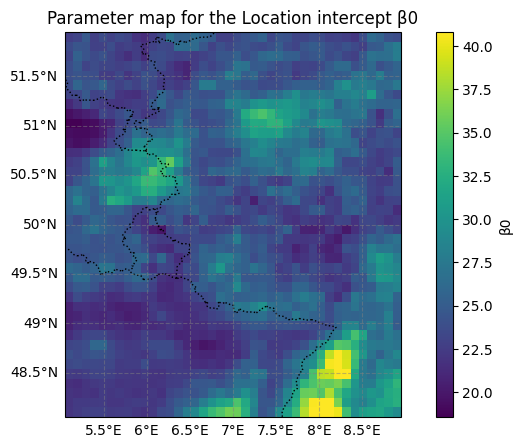

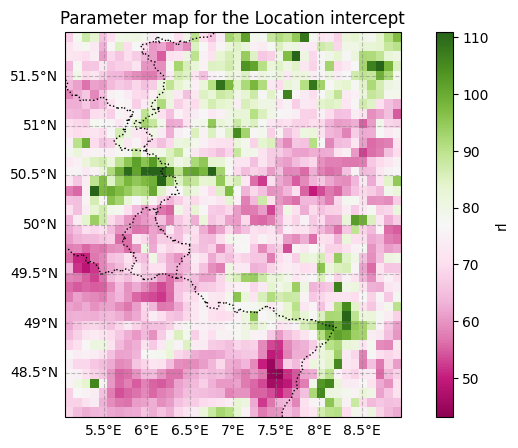

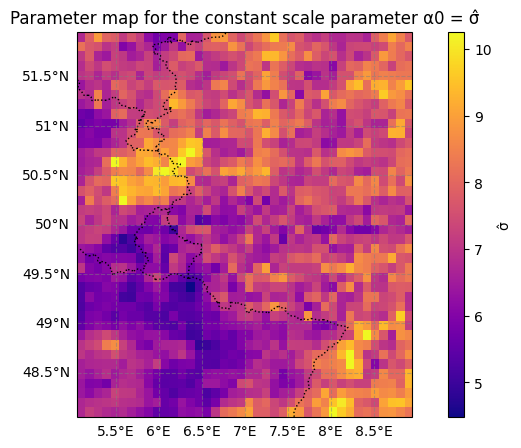

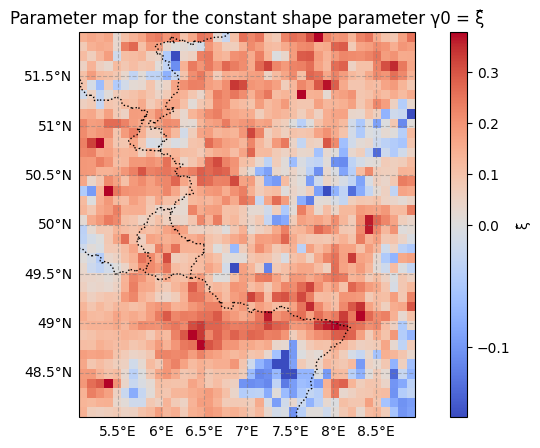

In [21]:
global_min = EOBS_gev_grid['location'].min()
global_max = EOBS_gev_grid['location'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)  # Continuous scale normalization
plot_datacube(EOBS_gev_grid, variable='location', cmap='viridis', norm=norm, title="Parameter map for the Location intercept β0", label="β0")


# b1 - Divergent scale around 0, retain 'coolwarm'
global_min = EOBS_gev_grid['rl'].min()
global_max = EOBS_gev_grid['rl'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)  # Continuous scale normalization
plot_datacube(EOBS_gev_grid, variable='rl', cmap='PiYG', norm=norm, title="Parameter map for the Location intercept", label="rl")

# Scale (sigma) - Continuous scale, use a sequential colormap like 'plasma'
global_min = EOBS_gev_grid['scale'].min()
global_max = EOBS_gev_grid['scale'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)  # Continuous scale normalization
plot_datacube(EOBS_gev_grid, variable='scale', cmap='plasma', norm=norm, title="Parameter map for the constant scale parameter α0 = σ̂", label="σ̂")

# Shape (Xi) - Divergent scale around 0, retain 'coolwarm'
global_min = EOBS_gev_grid['shape'].quantile(0.005)  # Lower bound for shape
global_max = EOBS_gev_grid['shape'].quantile(0.995)  # Upper bound for shape
norm = colors.TwoSlopeNorm(vmin=global_min, vcenter=0, vmax=global_max)  # Diverging around 0
plot_datacube(EOBS_gev_grid, variable='shape', cmap='coolwarm', norm=norm, title="Parameter map for the constant shape parameter γ0 = ξ̂", label="ξ̂")


ooo


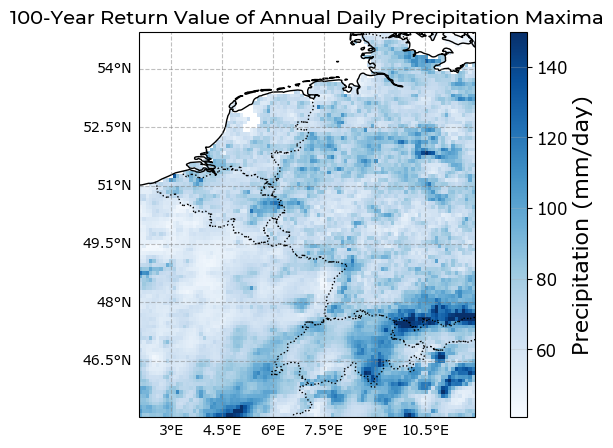

In [146]:
def plot_datacube(ds, variable='pr', time_step=0, ax=None, cbar_ax=None, fig=None, figsize=(5, 5), norm=None, interpolation=None, cmap='Blues', title=None, label=None, save_path=None, dpi=300):
    """
    Plot a single time step of the datacube for a specified variable, or just the data if no time dimension exists.

    Parameters:
    ds (xarray.Dataset): The dataset containing the data to be plotted.
    variable (str, optional): The name of the variable to plot. Default is 'pr'.
    time_step (int, optional): The time step to plot. Default is 0.
    ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis to plot on. Default is None.
    cbar_ax (matplotlib.axes._subplots.AxesSubplot, optional): Axis for the colorbar. Default is None.
    fig (matplotlib.figure.Figure, optional): Figure object for adding the colorbar. Default is None.
    figsize (tuple, optional): Figure size. Default is (5, 5).
    norm (optional): Normalization for color mapping. Default is None.
    interpolation (str, optional): Interpolation method for imshow. Default is None.
    cmap (str or Colormap, optional): Colormap for the plot. Default is 'Blues'.
    title (str, optional): Custom title for the plot. Default is None.
    label (str, optional): Custom label for the colorbar. Default is None (will use variable name and units).
    save_path (str, optional): Full path (including filename) where the figure should be saved. If provided, the directory will be created automatically. Default is None (do not save).
    dpi (int, optional): Resolution (dots per inch) when saving the figure. Default is 300.
    """
    # Create axes and figure if not provided
    if ax is None or cbar_ax is None or fig is None:
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 0.05])
        ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
        cbar_ax = fig.add_subplot(gs[0, 1])

    # Check if the variable exists in the dataset
    if variable not in ds:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")

    # Select data and set default title
    if 'time' in ds.dims:
        data = ds[variable].isel(time=time_step)
        if title is None:
            title = f"{variable.upper()} Plot for Date: {str(ds.time.values[time_step])}"
    else:
        data = ds[variable]
        if title is None:
            title = f"{variable.upper()} Plot"

    # Plot the data
    img = ax.imshow(
        data,
        origin='lower',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extent=[ds['lon'].min(), ds['lon'].max(), ds['lat'].min(), ds['lat'].max()],
        interpolation=interpolation,
        norm=norm,
    )

    # Ensure correct aspect ratio
    ax.set_aspect('auto')

    # Add geographic features
    ax.coastlines()
    ax.add_feature(ftr.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    ax.set_title(title, fontsize=9, fontproperties=montserrat_fp, fontweight='bold')

    # Update colorbar with the variable's name and units
    units = ds[variable].attrs.get('units', '')
    if label is None:
        fig.colorbar(img, ax=ax, cax=cbar_ax, shrink=0.5, aspect=1, label=f"{variable} ({units})")
    else:
        fig.colorbar(img, ax=ax, cax=cbar_ax, shrink=0.5, aspect=1, label=label)

    # Save the figure if a path is provided
    if save_path is not None:
        print("ooo")
        directory = os.path.dirname(save_path)
        if directory != "":  # Create directory only if a directory is specified
            os.makedirs(directory, exist_ok=True)
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')

    # Show the plot only if we created the axes and figure in this function
    if ax is None or cbar_ax is None or fig is None:
        plt.show()


import matplotlib.font_manager as fm
plt.rcParams['font.family'] = "Verdana"
montserrat_fp = fm.FontProperties(fname=r"c:\Users\paulusr\Downloads\Montserrat\static\Montserrat-Medium.ttf")
# b1 - Divergent scale around 0, retain 'coolwarm'
global_min = EOBS_gev_grid['rl'].min()
global_max = EOBS_gev_grid['rl'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)  # Continuous scale normalization
plot_datacube(EOBS_gev_grid, variable='rl', cmap='Blues', norm=norm, title="100-Year Return Value of Annual Daily Precipitation Maxima", label="Precipitation (mm/day)", save_path=r"c:\Users\paulusr\Documents\SavedFigures")

In [ ]:
import matplotlib.font_manager as fm

font_path = "./fonts/Montserrat-Regular.ttf"  # Update with your actual path
font_prop = fm.FontProperties(fname=font_path)

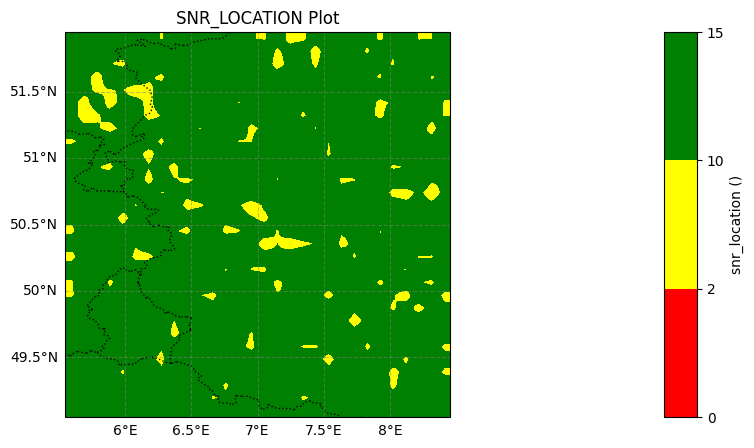

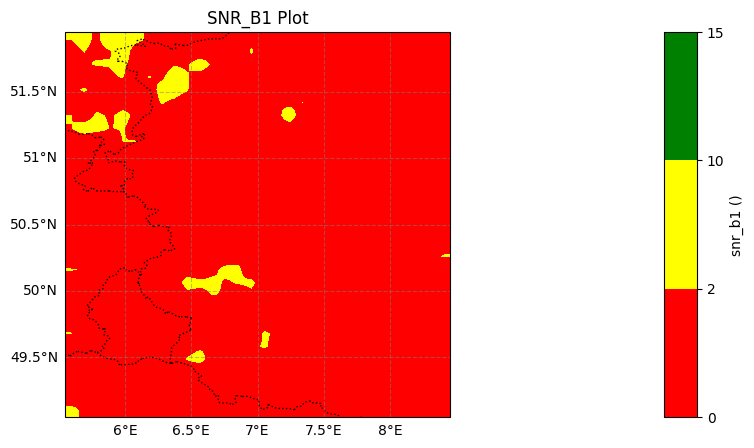

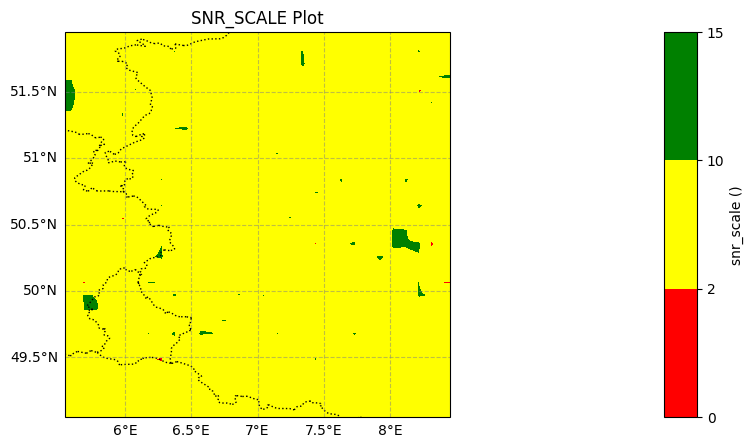

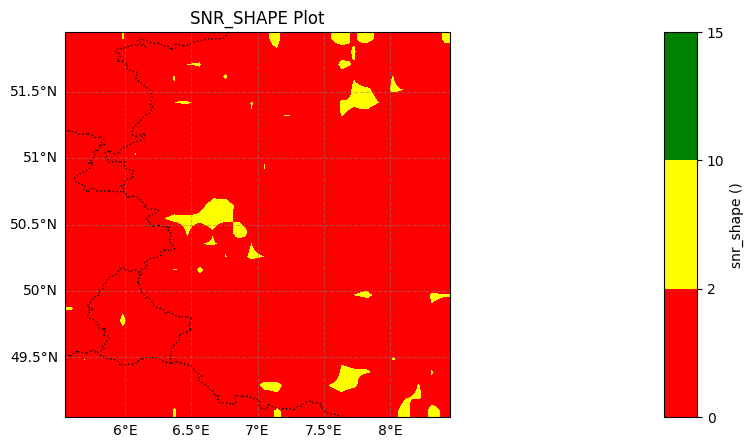

In [64]:
import matplotlib.colors as colors

# Define SNR boundaries for precision levels
vmin = 0  # Minimum possible SNR
vmax = 15  # Cap SNR visualization at 15 for better contrast
bounds = [0, 2, 10, 15]  # Key thresholds: poor, acceptable, good precision
cmap = colors.ListedColormap(['red', 'yellow', 'green'])  # Colors for thresholds
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot for SNR of 'snr_location'
plot_datacube(
    EOBS_gev_grid,
    variable='snr_location',
    cmap=cmap,
    norm=norm,
    interpolation='bilinear',
)

plot_datacube(
    EOBS_gev_grid,
    variable='snr_b1',
    cmap=cmap,
    norm=norm,
    interpolation='bilinear',
)

# Plot for SNR of 'snr_scale'
plot_datacube(
    EOBS_gev_grid,
    variable='snr_scale',
    cmap=cmap,
    norm=norm,
    interpolation='bilinear',
)

# Plot for SNR of 'snr_shape'
plot_datacube(
    EOBS_gev_grid,
    variable='snr_shape',
    cmap=cmap,
    norm=norm,
    interpolation='bilinear',
)


In [154]:
def fit_gev_model_with_t_statistic(ds, exog={'location':EOBS["tempanomalyMean"]}, h0_loc=0, h0_scale=0, h0_shape=0):
    """
    Fit a GEV model to each spatial pixel's time series of prmax values,
    compute the t-statistic for each parameter against user-defined null hypothesis values (H0),
    and return a binary xarray.Dataset indicating where H0 is true (1) or false (0).

    Parameters:
    ds (xarray.Dataset): The dataset containing the annual maximum precipitation ('prmax') for each pixel.
    exog (array-like): The exogenous variables used in the GEV model.
    h0_loc (float): The null hypothesis value for the location parameter (default = 0).
    h0_scale (float): The null hypothesis value for the scale parameter (default = 0).
    h0_shape (float): The null hypothesis value for the shape parameter (default = 0).

    Returns:
    xarray.Dataset: A binary Dataset (0 or 1) indicating whether H0 is true for each parameter.
    """
    # Initialize arrays to store binary results for each parameter
    shape_h0 = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    location_h0 = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    scale_h0 = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    
    # Loop over each spatial pixel
    for i, lat in enumerate(ds['lat'].values):
        for j, lon in enumerate(ds['lon'].values):
            # Extract the time series for the current pixel
            prmax_series = ds['pr'].sel(lat=lat, lon=lon).values

            # Check if the time series is valid (e.g., not all NaNs)
            if np.any(~np.isnan(prmax_series)):
                # Fit the GEV model
                model = GEVLikelihood(endog=prmax_series, exog=exog, full_output=True)
                fit_result = model.fit()

                # Extract fitted parameters and standard errors
                theta_hat = fit_result.fitted_params
                se_params = fit_result.SE()  # Standard errors for all parameters

                # Compute t-statistics for each parameter
                t_shape = (theta_hat[3] - h0_shape) / se_params[3] if se_params[3] > 0 else np.nan
                t_location = (theta_hat[1] - h0_loc) / se_params[1] if se_params[1] > 0 else np.nan
                t_scale = (theta_hat[2] - h0_scale) / se_params[1] if se_params[1] > 0 else np.nan

                # Compute critical value for two-tailed test (95% confidence level)
                critical_value = 2

                # Store results as 1 if H0 cannot be rejected (|t| < critical_value)
                shape_h0[i, j] = t_shape
                location_h0[i, j] = t_location
                scale_h0[i, j] = 0 if t_scale <= critical_value else 1

    # Create a Dataset to store the binary results
    h0_test_results_ds = xr.Dataset(
        {
            'shape_h0': (['lat', 'lon'], shape_h0),
            'location_h0': (['lat', 'lon'], location_h0),
            'scale_h0': (['lat', 'lon'], scale_h0)
        },
        coords={
            'lat': ds['lat'],
            'lon': ds['lon']
        }
    )
    
    return h0_test_results_ds


h0_test_results = fit_gev_model_with_t_statistic(EOBS_blockmax_grid,h0_loc=0,h0_scale=12,h0_shape=0)
h0_test_results

C:\Users\paulusr\AppData\Local\Temp\ipykernel_21688\3819837145.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_h0 = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_21688\3819837145.py:19: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_h0 = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_21688\3819837145.py:20: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To a

<xarray.Dataset> Size: 22kB
Dimensions:      (lat: 30, lon: 30)
Coordinates:
  * lat          (lat) float64 240B 49.05 49.15 49.25 ... 51.75 51.85 51.95
  * lon          (lon) float64 240B 5.55 5.65 5.75 5.85 ... 8.15 8.25 8.35 8.45
Data variables:
    shape_h0     (lat, lon) float64 7kB 1.433 0.7189 0.7884 ... 0.9886 2.254
    location_h0  (lat, lon) float64 7kB 2.396 1.733 1.521 ... 0.2854 1.416
    scale_h0     (lat, lon) float64 7kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

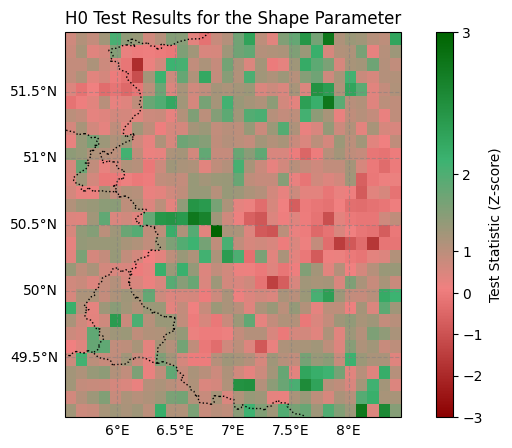

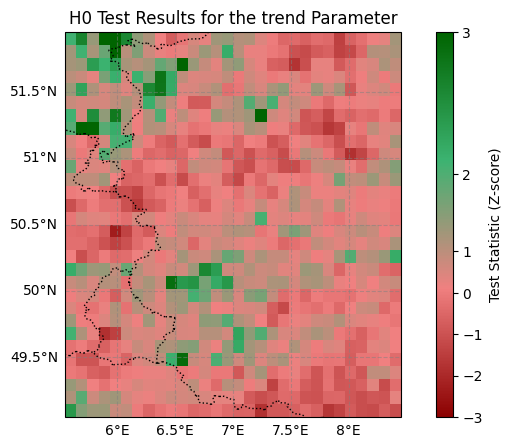

In [156]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

# Critical value for the 95% percentile of the normal distribution
critical_value = 1.645  # Z-score for 95% in one-tailed normal distribution

# Define a custom colormap for the continuum
cmap = colors.LinearSegmentedColormap.from_list(
    'critical_red_green',  # Name of the colormap
    ['darkred', 'lightcoral', 'mediumseagreen', 'darkgreen'],  # Gradient from red to green
)

# Define normalization for the colormap
norm = colors.TwoSlopeNorm(
    vmin=-3,  # Minimum Z-score
    vcenter=critical_value,  # Critical value for transition
    vmax=3   # Maximum Z-score
)


# Plot using the custom colormap
plot_datacube(
    h0_test_results,
    variable='shape_h0',
    cmap=cmap,
    norm=norm,
    title="H0 Test Results for the Shape Parameter",
    label="Test Statistic (Z-score)"
)
# Display the plot
plt.show()

plot_datacube(
    h0_test_results,
    variable='location_h0',
    cmap=cmap,
    norm=norm,
    title="H0 Test Results for the trend Parameter",
    label="Test Statistic (Z-score)"
)
plt.show()

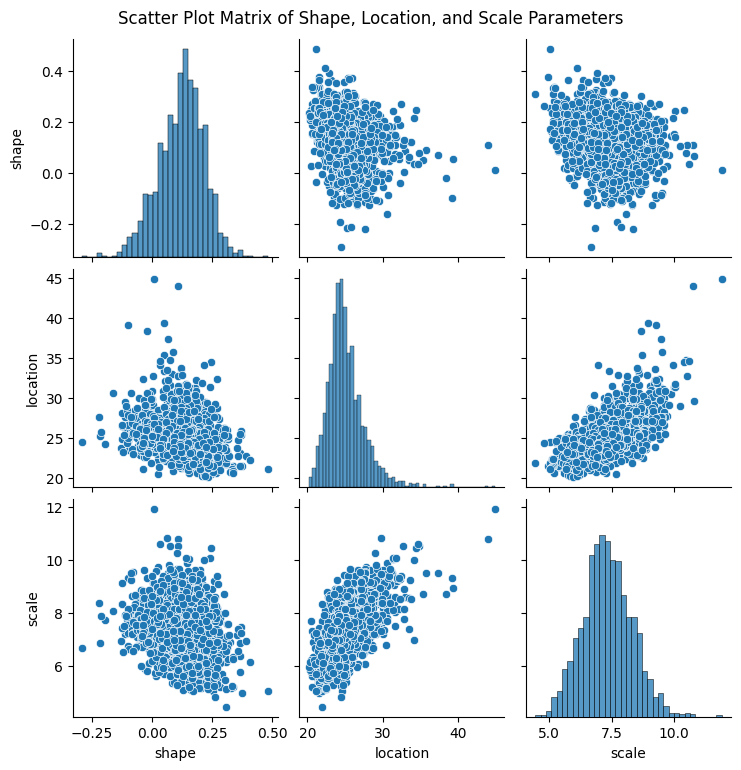

In [97]:
df = EOBS_gev_grid.to_dataframe().reset_index()

# Plot pairwise scatter plots for 'shape', 'location', and 'scale'
sns.pairplot(df, vars=['shape', 'location', 'scale'], kind='scatter')
plt.suptitle("Scatter Plot Matrix of Shape, Location, and Scale Parameters", y=1.02)
plt.show()

Checking all the ensembles (BOXPLOT OF SHAPE)

In [16]:
a = xr.open_dataset(r"c:\ThesisData\EOBS\RainfallEnsembles\rr_ensemble_0.1deg_reg_1953_v30.0e.nc")
print(a)

b = xr.open_dataset(r"c:\ThesisData\EOBS\RainFallMeanEnsemble\rr_ens_mean_0.1deg_reg_v30.0e.nc")
print(b)

<xarray.Dataset> Size: 10GB
Dimensions:    (longitude: 705, latitude: 465, ensemble: 20, time: 365)
Coordinates:
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * ensemble   (ensemble) int32 80B 1 2 3 4 5 6 7 8 ... 13 14 15 16 17 18 19 20
  * time       (time) datetime64[ns] 3kB 1953-01-01 1953-01-02 ... 1953-12-31
Data variables:
    rr         (time, ensemble, latitude, longitude) float32 10GB ...
<xarray.Dataset> Size: 36GB
Dimensions:    (latitude: 465, longitude: 705, time: 27210)
Coordinates:
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
  * time       (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30
Data variables:
    rr         (time, latitude, longitude) float32 36GB ...
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    Reference

In [43]:
EOBS_Summer_FULL = assemble_datacube(r"c:\ThesisData\EOBS\RainfallEnsembles")
EOBS_Summer_FULL

NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT
NEXT


<xarray.Dataset> Size: 2GB
Dimensions:   (time: 13664, ensemble: 20, lat: 40, lon: 40)
Coordinates:
  * lon       (lon) float64 320B 5.05 5.15 5.25 5.35 ... 8.65 8.75 8.85 8.95
  * lat       (lat) float64 320B 48.55 48.65 48.75 48.85 ... 52.25 52.35 52.45
  * ensemble  (ensemble) int32 80B 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
  * time      (time) object 109kB 1950-04-01 00:00:00 ... 2024-07-31 00:00:00
Data variables:
    pr        (time, ensemble, lat, lon) float32 2GB 5.9 5.8 2.7 ... 0.0 0.0 0.0

In [ ]:
EOBS_gev_grid = fit_gev_model(block_maximum_grid(EOBS_Summer_FULL.isel(ensemble=0)))
EOBS_gev_grid

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

<xarray.Dataset> Size: 77kB
Dimensions:       (lat: 40, lon: 40)
Coordinates:
  * lat           (lat) float64 320B 48.55 48.65 48.75 ... 52.25 52.35 52.45
    ensemble      int32 4B 1
  * lon           (lon) float64 320B 5.05 5.15 5.25 5.35 ... 8.65 8.75 8.85 8.95
Data variables:
    shape         (lat, lon) float64 13kB 0.1414 0.09787 ... 0.07076 0.08709
    location      (lat, lon) float64 13kB 26.5 27.54 25.34 ... 22.69 23.34 22.95
    scale         (lat, lon) float64 13kB 7.61 7.832 7.381 ... 6.743 7.093 7.141
    snr_shape     (lat, lon) float64 13kB 1.643 0.9067 1.458 ... 0.5687 0.9317
    snr_location  (lat, lon) float64 13kB 26.87 26.29 25.32 ... 21.33 13.03
    snr_scale     (lat, lon) float64 13kB 10.05 9.714 9.618 ... 4.885 8.897

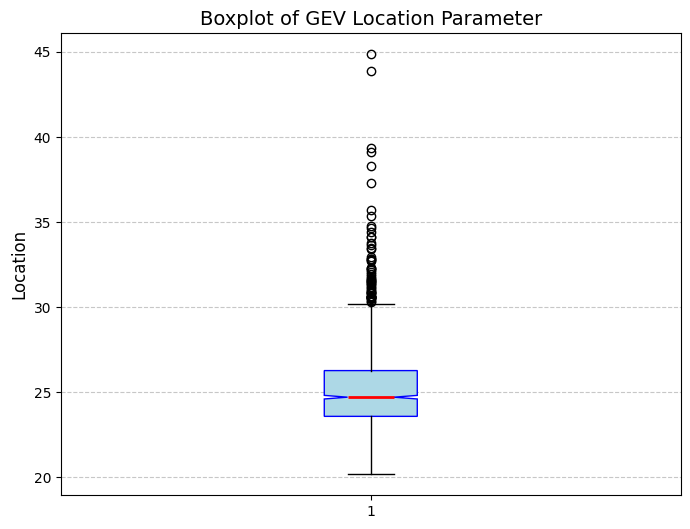

In [80]:
def plot_gev_boxplot(gev_ds, param):
    """
    Plot a boxplot for a specific GEV parameter across all spatial pixels.

    Parameters:
    gev_ds (xarray.Dataset): The dataset containing the GEV parameters.
    param (str): The parameter to plot ('shape', 'location', or 'scale').
    """
    if param not in gev_ds.data_vars:
        raise ValueError(f"{param} is not a valid parameter in the dataset.")

    # Flatten the parameter data (remove NaNs)
    param_data = gev_ds[param].values.flatten()
    param_data = param_data[~np.isnan(param_data)]

    # Create a boxplot
    plt.figure(figsize=(8, 6))
    plt.boxplot(param_data, vert=True, patch_artist=True, notch=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))
    plt.title(f"Boxplot of GEV {param.capitalize()} Parameter", fontsize=14)
    plt.ylabel(param.capitalize(), fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_gev_boxplot(EOBS_gev_grid,"location")

In [63]:
def fit_gev_ensembles(ds,n):
    """
    Fit GEV models for the first two ensembles in the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing the precipitation data ('rr').

    Returns:
    dict: A dictionary with ensemble indices as keys and GEV parameter datasets as values.
    """
    gev_results = {}
    for ensemble_idx in range(n):  # Test with the first two ensembles
        print(f"Fitting GEV model for ensemble {ensemble_idx}...")
        ensemble_ds = ds.isel(ensemble=ensemble_idx)  # Select a single ensemble
        # Apply block maximum grid and fit the GEV model
        gev_results[ensemble_idx] = fit_gev_model(block_maximum_grid(ensemble_ds))
    return gev_results

# Test GEV fitting for two ensembles
all_gev_grids = fit_gev_ensembles(EOBS_Summer_FULL,20)

Fitting GEV model for ensemble 0...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 1...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 2...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 3...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 4...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 5...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 6...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 7...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 8...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 9...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 10...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 11...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 12...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 13...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 14...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 15...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 16...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 17...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 18...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

Fitting GEV model for ensemble 19...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
C:\Users\paulusr\AppData\Local\Temp\ipykernel_11328\2552261272.py:17: FutureWarning: The return type of `Dataset.di

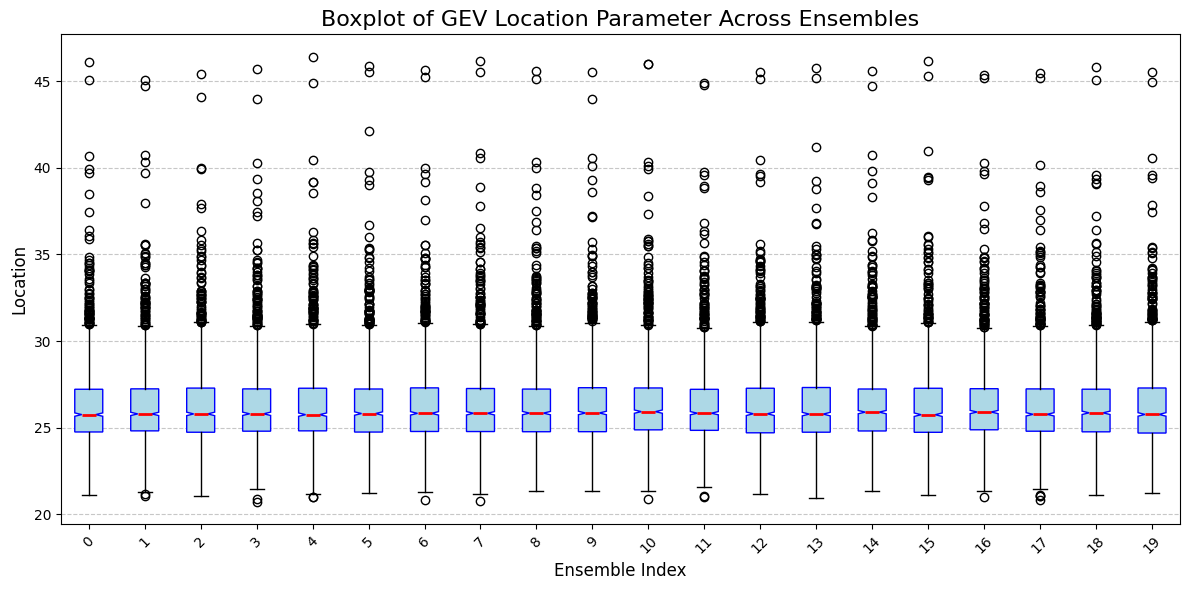

In [79]:
def plot_ensemble_boxplots(gev_results, param):
    """
    Plot side-by-side boxplots for a specific GEV parameter across all ensembles.

    Parameters:
    gev_results (dict): A dictionary containing GEV parameter datasets for each ensemble.
    param (str): The parameter to plot ('shape', 'location', or 'scale').
    """
    all_ensemble_data = []

    # Extract parameter data for each ensemble
    for ensemble_idx, gev_ds in gev_results.items():
        if param not in gev_ds.data_vars:
            raise ValueError(f"{param} is not a valid parameter in the dataset for ensemble {ensemble_idx}.")
        
        param_data = gev_ds[param].values.flatten()
        param_data = param_data[~np.isnan(param_data)]
        all_ensemble_data.append(param_data)

    # Create side-by-side boxplots
    plt.figure(figsize=(12, 6))
    plt.boxplot(all_ensemble_data, vert=True, patch_artist=True, notch=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2))

    plt.title(f"Boxplot of GEV {param.capitalize()} Parameter Across Ensembles", fontsize=16)
    plt.xlabel("Ensemble Index", fontsize=12)
    plt.ylabel(param.capitalize(), fontsize=12)
    plt.xticks(ticks=range(1, len(all_ensemble_data) + 1), labels=range(len(all_ensemble_data)), rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
plot_ensemble_boxplots(all_gev_grids,"location")

In [ ]:
def fit_gev_model(ds, exog={}):
    """
    Fit a GEV model to each spatial pixel's time series of prmax values,
    compute the signal-to-noise ratio (SNR) for each parameter,
    and store the results in an xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing the annual maximum precipitation ('prmax') for each pixel.
    exog (array-like): The exogenous variables used in the GEV model.

    Returns:
    xarray.Dataset: A Dataset containing the fitted parameters and SNR for each spatial pixel.
    """
    # Initialize arrays to store the model parameters and SNR for each pixel
    shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    location_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    scale_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    snr_shape = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    snr_location = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    snr_scale = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    
    # Loop over each spatial pixel
    for i, lat in enumerate(ds['lat'].values):
        for j, lon in enumerate(ds['lon'].values):
            # Extract the time series for the current pixel
            prmax_series = ds['pr'].sel(lat=lat, lon=lon).values

            # Check if the time series is valid (e.g., not all NaNs)
            if np.any(~np.isnan(prmax_series)):
                # Fit the GEV model
                model = GEVLikelihood(endog=prmax_series, exog=exog, full_output=True)
                fit_result = model.fit()

                # Store the fitted parameters
                location_param[i, j] = fit_result.fitted_params[0]
                scale_param[i, j] = fit_result.fitted_params[1]
                shape_param[i, j] = fit_result.fitted_params[2]

                # Compute SNR for each parameter
                se_params = fit_result.SE()  # Standard errors for all parameters
                if se_params[0] > 0:  # Avoid division by zero
                    snr_location[i, j] = location_param[i, j] / se_params[0]
                if se_params[1] > 0:
                    snr_scale[i, j] = scale_param[i, j] / se_params[1]
                if se_params[2] > 0:
                    snr_shape[i, j] = shape_param[i, j] / se_params[2]

    # Create a Dataset to store the fitted parameters and SNR
    fitted_params_ds = xr.Dataset(
        {
            'shape': (['lat', 'lon'], shape_param),
            'location': (['lat', 'lon'], location_param),
            'scale': (['lat', 'lon'], scale_param),
            'snr_shape': (['lat', 'lon'], snr_shape),
            'snr_location': (['lat', 'lon'], snr_location),
            'snr_scale': (['lat', 'lon'], snr_scale)
        },
        coords={
            'lat': ds['lat'],
            'lon': ds['lon']
        }
    )
    
    return fitted_params_ds


#EOBS_gev_grid = fit_gev_model(EOBS_blockmax_grid)
#EOBS_gev_grid

OLD CODE

In [ ]:
center_coordinates = (7.0, 50.5)  # Center around Ahr-Eifel basin (longitude, latitude)
side_length = 2  # Side length of the square in degrees
EOBS_gev_large_w = fit_gev_model(block_maximum_grid(mask_time(
    mask_square(
        load_netcdf(filepath=r"c:\ThesisData\E_OBS\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
        center_coordinates,
        side_length
    ),
    season='winter'
)))
global_min = EOBS_gev_large_w['shape'].quantile(0.005)
global_max = EOBS_gev_large_w['shape'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large_w,variable='shape',cmap='coolwarm',norm=norm,interpolation='bilinear')
global_min = EOBS_gev_large_w['location'].min()
global_max = EOBS_gev_large_w['location'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large_w,variable='location',cmap='coolwarm',norm=norm,interpolation='bilinear')
global_min = -0.3
global_max = EOBS_gev_large_w['scale'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large_w,variable='scale',cmap='coolwarm',norm=norm,interpolation='bilinear')

In [ ]:
center_coordinates = (7.0, 50.5)  # Center around Ahr-Eifel basin (longitude, latitude)
side_length = 15  # Side length of the square in degrees
EOBS_gev_large = fit_gev_model(block_maximum_grid(mask_time(
    mask_square(
        load_netcdf(filepath=r"c:\ThesisData\E_OBS\rr_ens_mean_0.1deg_reg_v30.0e.nc", coords=('rr', 'latitude', 'longitude')),
        center_coordinates,
        side_length
    ),
    season='summer'
)))

In [ ]:
global_min = EOBS_gev_large['shape'].min()
global_max = EOBS_gev_large['shape'].quantile(0.95)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large,variable='shape',cmap='coolwarm',norm=norm)
global_min = EOBS_gev_large['location'].min()
global_max = EOBS_gev_large['location'].quantile(0.95)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_large,variable='location',cmap='coolwarm',norm=norm)
global_min = -0.2
global_max = EOBS_gev_large['scale'].quantile(0.975)
norm = colors.TwoSlopeNorm(vmin=global_min, vcenter=0, vmax=global_max)
plot_datacube(EOBS_gev_large,variable='scale',cmap='coolwarm',norm=norm)

In [ ]:
EOBS = pd.read_csv(r"c:\ThesisData\OUTPUTS\UCL_blockmax.csv")
def fit_gevTradowsky_model(ds, exog={'location':EOBS['tempanomalyMean'].values, 'scale':EOBS['tempanomalyMean'].values}):
    """
    Fit a GEV model to each spatial pixel's time series of prmax values and store the results in an xarray Dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing the annual maximum precipitation ('prmax') for each pixel.
    exog (array-like): The exogenous variables used in the GEV model.

    Returns:
    xarray.Dataset: A Dataset containing the fitted parameters for each spatial pixel.
    """
    # Initialize arrays to store the model parameters for each pixel
    alpha_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    shape_param = np.full((ds.dims['lat'], ds.dims['lon']), np.nan)
    
    # Loop over each spatial pixel
    for i, lat in enumerate(ds['lat'].values):
        for j, lon in enumerate(ds['lon'].values):
            # Extract the time series for the current pixel
            prmax_series = ds['pr'].sel(lat=lat, lon=lon).values
            
            # Check if the time series is valid (e.g., not all NaNs)
            if np.any(~np.isnan(prmax_series)):
                # Fit the GEV model
                model = GEVTradowsky(endog=prmax_series, exog=exog, full_output=True)
                fit_result = model.fit()
                
                # Store the fitted parameters
                alpha_param[i, j] = fit_result.like.x[0]
                shape_param[i, j] = fit_result.like.x[1]


    # Create a Dataset to store the fitted parameters
    fitted_params_ds = xr.Dataset(
        {
            'alpha': (['lat', 'lon'], alpha_param),
            'shape': (['lat', 'lon'], shape_param),
        },
        coords={
            'lat': ds['lat'],
            'lon': ds['lon']
        }
    )
    
    return fitted_params_ds

EOBS_gev_grid_tr = fit_gevTradowsky_model(EOBS_blockmax_grid)
EOBS_gev_grid_tr

In [ ]:
global_min = EOBS_gev_grid_tr['alpha'].quantile(0.005)
global_max = EOBS_gev_grid_tr['alpha'].quantile(0.995)
norm = colors.Normalize(vmin=global_min, vmax=global_max)
plot_datacube(EOBS_gev_grid_tr,variable='alpha',cmap='coolwarm',norm=norm,interpolation='bilinear')
global_min = EOBS_gev_grid_tr['shape'].quantile(0.005)
global_max = EOBS_gev_grid_tr['shape'].quantile(0.995)
norm = colors.TwoSlopeNorm(vmin=global_min, vcenter=0, vmax=global_max)
plot_datacube(EOBS_gev_grid_tr,variable='shape',cmap='coolwarm',norm=norm,interpolation='bilinear')

In [ ]:
df = EOBS_gev_grid_tr.to_dataframe().reset_index()

sns.pairplot(df, vars=['alpha', 'shape'], kind='scatter')
plt.suptitle("Scatter Plot Matrix of Aplha shape Parameters", y=1.02)
plt.show()

## 📘 R : Library Import and Global Variable Definition

In this section, I import the necessary libraries 📦 for data manipulation and analysis in R. Additionally, I define global variables 🌐 (mostly path-related), which can be reused throughout the code for various locations or users.

We switch To R to fit the GEV now that we have our dataset(s) ready and built. We will use ismev for estimation and ggplot for plotting.

In [ ]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(ismev)

In [ ]:
EOBS <- read.csv("c:\\ThesisData\\OUTPUTS\\UCL_blockmax.csv")
#UCL <- read.csv("c:\\Users\\bobel\\OneDrive - Université de Namur\\Data\\Blockmax\\UCL_blockmax.csv")

In [ ]:
ggplot(EOBS, aes(x = tempanomalyMean, y = prmax)) +
  geom_point(color = 'blue', size = 3, alpha = 0.7) +
  labs(
    title = "Maximum Precipitation vs Temperature Anomaly",
    x = "Temperature Anomaly (Mean)",
    y = "Maximum Precipitation (prmax)"
  ) +
  theme_minimal() +  # A simple, clean theme for the plot
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    panel.grid.major = element_line(size = 0.5, linetype = "dotted", color = "gray")
  )

In [ ]:
ydat <- as.matrix(EOBS$tempanomalyMean) 
# Model 1 : Stationary GEV
fit_stationary = gev.fit(xdat = EOBS$prmax, ydat = ydat,mul = 1,)
xlow <- 100 # Example lower bound
xup <- 300   # Example upper bound

fit_stationary
#gev.prof(z=fit_stationary, m = 1000,  xlow = xlow,xup = xup)
#mod test

In [ ]:
xdat <- EOBS$prmax
ydat <- as.matrix(EOBS$tempanomalyMean)  # Convert the covariate to a matrix format
xdat_positive <- xdat/100

fit_trend <- gev.fit(
  xdat = xdat_positive,
  ydat = ydat,
  mul = 1,
  sigl = 1,
  maxit = 100000,
  siglink = exp,
  method = "L-BFGS-B"    # No covariate for the shape parameter
)

gev.diag(fit_trend)

In [ ]:
gev_statistical_summary_dynamic <- function(z=gev_fit_result,scale=NULL) {
  # Extracting elements from the GEV fit result
  nllh <- z$nllh
  mle <- z$mle
  se <- z$se
  conv <- z$conv
  n <- length(z$data)  # Number of observations
  k <- length(mle)  # Number of parameters
  
  # AIC and BIC calculation
  aic <- 2 * k + 2 * nllh
  bic <- log(n) * k + 2 * nllh
  
  # t-values (mle / se)
  t_values <- mle / se
  
  # p-values using normal approximation for large sample sizes
  p_values <- 2 * pnorm(-abs(t_values))  # Two-sided test
  
  # Create a significance level code
  significance_codes <- cut(p_values, 
                            breaks = c(-Inf, 0.001, 0.01, 0.05, 0.1, Inf), 
                            labels = c("***", "**", "*", ".", " "), 
                            right = FALSE)
  
  # Print the header
  if (is.null(scale)) {
    cat("GEV Fit Results\n")
  } else {
    c = paste("GEV Fit Results (Scale: ", scale, ")\n",sep = "")
    cat(c)
  }
  cat("=====================================\n")
  
  # Print negative log-likelihood
  cat("Negative Log-Likelihood:", round(nllh, 4), "\n")
  
  # Print AIC and BIC
  cat("AIC:", round(aic, 4), "\n")
  cat("BIC:", round(bic, 4), "\n")
  
  # Coefficient summary table
  cat("\nCoefficients:\n")
  
  # Dynamically label parameters
  param_names <- c("Shape")  # First parameter is always the shape
  
  # Add placeholders for additional parameters
  if (length(mle) > 1) {
    # If there are more than just the shape parameter, label the rest generically
    for (i in 2:length(mle)) {
      param_names <- c(param_names, paste0("par", i - 1))
    }
  }
  
  # Build a dataframe for results
  results <- data.frame(
    `Estimate` = mle,
    `StdError` = se,
    "t|Value" = t_values,
    `Prob.t` = p_values,
    `Codes` = significance_codes
  )

  return <- list(
    Model = deparse(substitute(z)),
    AIC = aic,
    BIC = bic,
    ParamQty = k,
    Scale = scale
  )
  rownames(results) <- param_names
  
  print(results, row.names = TRUE)
  
  # Convergence status
  cat("\nConvergence status (0 means successful):", conv, "\n")
  
  # Significance codes explanation
  cat("---\n")
  cat("Codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1\n")
  
  # Return the result invisibly for further use
  return
}

# Usage Example:
# Assuming `fit` is the result from calling gev.fit() on your data:
gev_statistical_summary_dynamic(z=fit_stationary,scale="max")


In [ ]:
xdat <- EOBS$prmax
ydat <- as.matrix(EOBS$tempanomalyMean)  # Convert the covariate to a matrix format

fit_tra = gev.fit(xdat_positive, 
        ydat = ydat,  # Covariate matrix with T_prime (e.g., temperature)
        mul = 1,                 # Use the first column of ydat for mu (location)
        sigl = 1,                # Use the first column of ydat for sigma (scale)          # Shape parameter is constant (xi)          # Log link for mu
        mulink = exp  ,       # Log link for sigma   # Identity link for xi (constant shape)
        maxit = 10000)

gev.diag(fit_tra)